# Part 0: Import Libraries

## Import general libraries

In [1]:
# For data exploration, data clenaing, and visualization 
import os
import io
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For data preprossing and feature enginnering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# For displaying max number of lines
pd.set_option("display.max_rows", 500)

# For reproducability
SEED = 1

## Load SageMaker resources

In [2]:
# sagemaker related libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

In [3]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

In [6]:
sagemaker_session

In [7]:
role

'arn:aws:iam::873710589365:role/service-role/AmazonSageMaker-ExecutionRole-20201018T181647'

In [8]:
bucket

'sagemaker-us-east-1-873710589365'

In [9]:
#data_dir = 'data/Input' # the Notebook folder we will use for storing raw data

# specify where to upload in S3
#prefix = 'Arvato/Input'

# upload to S3
#input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
#print(input_data)

## Download raw data files from S3 as local files

In [7]:
data_dir = 'data/Input'

# specify where to upload in S3
prefix = 'Arvato/Input'

!mkdir ./data/Input/

!aws s3 cp s3://sagemaker-us-east-1-873710589365/Arvato/Input/Udacity_AZDIAS_052018.csv ./data/Input/
!aws s3 cp s3://sagemaker-us-east-1-873710589365/Arvato/Input/Udacity_CUSTOMERS_052018.csv ./data/Input/
!aws s3 cp s3://sagemaker-us-east-1-873710589365/Arvato/Input/Udacity_MAILOUT_052018_TEST.csv ./data/Input/
!aws s3 cp s3://sagemaker-us-east-1-873710589365/Arvato/Input/Udacity_MAILOUT_052018_TRAIN.csv ./data/Input/


Unknown options: -,Values,2017.xlsx,./data/Input/

Unknown options: Levels,-,Attributes,2017.xlsx,./data/Input/
download: s3://sagemaker-us-east-1-873710589365/Arvato/Input/Udacity_AZDIAS_052018.csv to data/Input/Udacity_AZDIAS_052018.csv
download: s3://sagemaker-us-east-1-873710589365/Arvato/Input/Udacity_CUSTOMERS_052018.csv to data/Input/Udacity_CUSTOMERS_052018.csv
download: s3://sagemaker-us-east-1-873710589365/Arvato/Input/Udacity_MAILOUT_052018_TEST.csv to data/Input/Udacity_MAILOUT_052018_TEST.csv
download: s3://sagemaker-us-east-1-873710589365/Arvato/Input/Udacity_MAILOUT_052018_TRAIN.csv to data/Input/Udacity_MAILOUT_052018_TRAIN.csv


In [8]:
!aws s3 cp "s3://sagemaker-us-east-1-873710589365/Arvato/Input/DIAS Attributes - Values 2017.xlsx" ./data/Input/
!aws s3 cp "s3://sagemaker-us-east-1-873710589365/Arvato/Input/DIAS Information Levels - Attributes 2017.xlsx" ./data/Input/

download: s3://sagemaker-us-east-1-873710589365/Arvato/Input/DIAS Attributes - Values 2017.xlsx to data/Input/DIAS Attributes - Values 2017.xlsx
download: s3://sagemaker-us-east-1-873710589365/Arvato/Input/DIAS Information Levels - Attributes 2017.xlsx to data/Input/DIAS Information Levels - Attributes 2017.xlsx


# Part 1: Data Exploration, Cleaning, and Visualization

## Data Exploration

### Load attribute value dataset

* attribute_values - includes a description of columns in azdias and customers data, information about range of values each column can take and their respective meanings

In [10]:
# Read attribute values for a first try
attributes_values = pd.read_excel('./data/Input/DIAS Attributes - Values 2017.xlsx', header=1)
attributes_values

Unnamed: 0 Attribute         Description Value  \
0            NaN  AGER_TYP  best-ager typology    -1   
1            NaN       NaN                 NaN     0   
2            NaN       NaN                 NaN     1   
3            NaN       NaN                 NaN     2   
4            NaN       NaN                 NaN     3   
...          ...       ...                 ...   ...   
2253         NaN       NaN                 NaN     2   
2254         NaN       NaN                 NaN     3   
2255         NaN       NaN                 NaN     4   
2256         NaN       NaN                 NaN     5   
2257         NaN       NaN                 NaN     6   

                         Meaning  
0                        unknown  
1     no classification possible  
2                passive elderly  
3               cultural elderly  
4      experience-driven elderly  
...                          ...  
2253                       smart  
2254               fair supplied  
2255                price driven  
2256         seeking orientation  
2257                 indifferent  

[2258 rows x 5 columns]

In [11]:
# Check for NaN info of each column 
attributes_values.isnull().sum()

Unnamed: 0     2258
Attribute      1944
Description    1907
Value             0
Meaning          11
dtype: int64

* "Unnamed" column is just an empty one with all "NaN" so we can ignore it while loading data 

In [12]:
# Reload attribute values but ignoring "Unnamed" column 
no_unamed = lambda x: 'Unnamed' not in x
attributes_values = pd.read_excel('./data/Input/DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
attributes_values

Attribute         Description Value                     Meaning
0     AGER_TYP  best-ager typology    -1                     unknown
1          NaN                 NaN     0  no classification possible
2          NaN                 NaN     1             passive elderly
3          NaN                 NaN     2            cultural elderly
4          NaN                 NaN     3   experience-driven elderly
...        ...                 ...   ...                         ...
2253       NaN                 NaN     2                       smart
2254       NaN                 NaN     3               fair supplied
2255       NaN                 NaN     4                price driven
2256       NaN                 NaN     5         seeking orientation
2257       NaN                 NaN     6                 indifferent

[2258 rows x 4 columns]

In [13]:
attributes_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    314 non-null    object
 1   Description  351 non-null    object
 2   Value        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB


* We can replace "unknown" values with "np.nan" values

### Load attribute information dataset

* attribute_info - includes detailed information about each column with additional notes 

In [15]:
# Read attribute information
attributes_info = pd.read_excel('./data/Input/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)
attributes_info

Information level                                          Attribute  \
0                   NaN                                           AGER_TYP   
1                Person                               ALTERSKATEGORIE_GROB   
2                   NaN                                          ANREDE_KZ   
3                   NaN                                      CJT_GESAMTTYP   
4                   NaN                                  FINANZ_MINIMALIST   
5                   NaN                                      FINANZ_SPARER   
6                   NaN                                   FINANZ_VORSORGER   
7                   NaN                                     FINANZ_ANLEGER   
8                   NaN                              FINANZ_UNAUFFAELLIGER   
9                   NaN                                   FINANZ_HAUSBAUER   
10                  NaN                                          FINANZTYP   
11                  NaN                                        GEBURTSJAHR   
12                  NaN                                    GFK_URLAUBERTYP   
13                  NaN                                   GREEN_AVANTGARDE   
14                  NaN                                         HEALTH_TYP   
15                  NaN                                LP_LEBENSPHASE_FEIN   
16                  NaN                                LP_LEBENSPHASE_GROB   
17                  NaN                                    LP_FAMILIE_FEIN   
18                  NaN                                    LP_FAMILIE_GROB   
19                  NaN                                     LP_STATUS_FEIN   
20                  NaN                                     LP_STATUS_GROB   
21                  NaN                                   NATIONALITAET_KZ   
22                  NaN                              PRAEGENDE_JUGENDJAHRE   
23                  NaN                                     RETOURTYP_BK_S   
24                  NaN                                          SEMIO_SOZ   
25                  NaN                                          SEMIO_FAM   
26                  NaN                                          SEMIO_REL   
27                  NaN                                          SEMIO_MAT   
28                  NaN                                         SEMIO_VERT   
29                  NaN                                         SEMIO_LUST   
30                  NaN                                          SEMIO_ERL   
31                  NaN                                         SEMIO_KULT   
32                  NaN                                          SEMIO_RAT   
33                  NaN                                         SEMIO_KRIT   
34                  NaN                                          SEMIO_DOM   
35                  NaN                                         SEMIO_KAEM   
36                  NaN                                      SEMIO_PFLICHT   
37                  NaN                                        SEMIO_TRADV   
38                  NaN                                        SHOPPER_TYP   
39                  NaN                                          SOHO_FLAG   
40                  NaN                                           TITEL_KZ   
41                  NaN                                           VERS_TYP   
42                  NaN                                           ZABEOTYP   
43            Household                                           ALTER_HH   
44                  NaN                                       ANZ_PERSONEN   
45                  NaN                                          ANZ_TITEL   
46                  NaN                                  HAUSHALTSSTRUKTUR   
47                  NaN                                 HH_EINKOMMEN_SCORE   
48                  NaN                                   D19_KK_KUNDENTYP   
49                  NaN                                      D19_KONSUMTYP   
50                  NaN  D19

In [16]:
attributes_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  10 non-null     object
 1   Attribute          313 non-null    object
 2   Description        313 non-null    object
 3   Additional notes   20 non-null     object
dtypes: object(4)
memory usage: 9.9+ KB


### Load "azdias" and "customers" datasets

"azdias" dataset

In [17]:
azdias = pd.read_csv('./data/Input/Udacity_AZDIAS_052018.csv', sep=';', usecols=no_unamed)
azdias

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0       910215        -1         NaN       NaN          NaN          NaN   
1       910220        -1         9.0       0.0          NaN          NaN   
2       910225        -1         9.0      17.0          NaN          NaN   
3       910226         2         1.0      13.0          NaN          NaN   
4       910241        -1         1.0      20.0          NaN          NaN   
...        ...       ...         ...       ...          ...          ...   
290394  531253        -1         NaN       NaN          NaN          NaN   
290395  531261        -1         9.0      18.0          NaN          NaN   
290396  531267        -1         9.0      17.0          NaN          NaN   
290397  531268        -1         1.0       0.0          NaN          NaN   
290398  723421        -1         4.0      20.0          NaN          NaN   

        ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0               NaN          NaN                   NaN                  NaN   
1               NaN          NaN                  21.0                 11.0   
2               NaN          NaN                  17.0                 10.0   
3               NaN          NaN                  13.0                  1.0   
4               NaN          NaN                  14.0                  3.0   
...             ...          ...                   ...                  ...   
290394          NaN          NaN                   NaN                  NaN   
290395          NaN          NaN                  18.0                 17.0   
290396          NaN          NaN                  17.0                 35.0   
290397          NaN          NaN                   NaN                 35.0   
290398          NaN          NaN                  20.0                  7.0   

        ...  VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0       ...  NaN       NaN         NaN      NaN             NaN   
1       ...  4.0       8.0        11.0     10.0             3.0   
2       ...  2.0       9.0         9.0      6.0             3.0   
3       ...  0.0       7.0        10.0     11.0             NaN   
4       ...  2.0       3.0         5.0      4.0             2.0   
...     ...  ...       ...         ...      ...             ...   
290394  ...  NaN       NaN         NaN      NaN             NaN   
290395  ...  4.0       8.0        10.0      7.0             6.0   
290396  ...  3.0       7.0        10.0      8.0             5.0   
290397  ...  3.0       8.0        10.0      7.0             NaN   
290398  ...  NaN       NaN         NaN      NaN             NaN   

        WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0                  NaN       NaN      3.0       1.0                  2.0  
1                  9.0       4.0      5.0       2.0                  1.0  
2                  9.0       2.0      5.0       2.0                  3.0  
3                  9.0       7.0      3.0       2.0                  4.0  
4                  9.0       3.0      4.0       1.0                  3.0  
...                ...       ...      ...       ...                  ...  
290394             NaN       NaN      3.0       2.0                  3.0  
290395             9.0       3.0      5.0       1.0                  2.0  
290396             9.0       4.0      5.0       1.0                  1.0  
290397             7.0       4.0      3.0       1.0                  4.0  
290398             NaN       NaN      NaN       NaN                  NaN  

[290399 rows x 366 columns]

In [18]:
print("Azdias shape -",azdias.shape)
print("Azdias columns -",azdias.columns)

Azdias shape - (290399, 366)
Azdias columns - Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=366)


In [19]:
# Take a look at the two columns with warning
print(azdias.columns[18:20])
warning_cols = list(azdias.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [20]:
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUG_2015"]

Attribute                             Description Value  Meaning
51  CAMEO_DEUG_2015  CAMEO classification 2015 - Uppergroup    -1  unknown

In [21]:
# "CAMEO_INTL_2015" ---> named as "CAMEO_DEUINTL_2015" in attribute values excel sheet
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUINTL_2015"]

Attribute                                        Description  \
105  CAMEO_DEUINTL_2015  CAMEO classification 2015 - international typo...   

    Value  Meaning  
105    -1  unknown

In [22]:
azdias[warning_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290399 entries, 0 to 290398
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  258798 non-null  object
 1   CAMEO_INTL_2015  258798 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


In [23]:
azdias[warning_cols[0]].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [24]:
azdias[warning_cols[1]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

"customers" dataset

In [25]:
customers = pd.read_csv('./data/Input/Udacity_CUSTOMERS_052018.csv', sep=';',usecols=no_unamed)
customers

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0         9626         2         1.0      10.0          NaN          NaN   
1         9628        -1         9.0      11.0          NaN          NaN   
2       143872        -1         1.0       6.0          NaN          NaN   
3       143873         1         1.0       8.0          NaN          NaN   
4       143874        -1         1.0      20.0          NaN          NaN   
...        ...       ...         ...       ...          ...          ...   
191647  154561         1         1.0       9.0          NaN          NaN   
191648  154563        -1         2.0       0.0          NaN          NaN   
191649  148813         2         1.0      15.0          NaN          NaN   
191650  148852         3         1.0      13.0          NaN          NaN   
191651  148883         3         1.0       0.0          NaN          NaN   

        ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0               NaN          NaN                  10.0                  1.0   
1               NaN          NaN                   NaN                  NaN   
2               NaN          NaN                   0.0                  1.0   
3               NaN          NaN                   8.0                  0.0   
4               NaN          NaN                  14.0                  7.0   
...             ...          ...                   ...                  ...   
191647          NaN          NaN                   9.0                  1.0   
191648          NaN          NaN                   0.0                  0.0   
191649          NaN          NaN                  10.0                  1.0   
191650          NaN          NaN                  13.0                  4.0   
191651          NaN          NaN                   9.0                  1.0   

        ...  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  \
0       ...      2.0             6.0             9.0       7.0         3   
1       ...      3.0             0.0             9.0       NaN         3   
2       ...     11.0             6.0             9.0       2.0         3   
3       ...      2.0             NaN             9.0       7.0         1   
4       ...      4.0             2.0             9.0       3.0         1   
...     ...      ...             ...             ...       ...       ...   
191647  ...      5.0             6.0             9.0       1.0         3   
191648  ...      4.0             NaN             9.0       3.0         3   
191649  ...      5.0             3.0             9.0       3.0         3   
191650  ...      1.0             4.0             9.0       2.0         3   
191651  ...      1.0             3.0             9.0       7.0         1   

            PRODUCT_GROUP  CUSTOMER_GROUP ONLINE_PURCHASE ANREDE_KZ  \
0       COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
1                    FOOD    SINGLE_BUYER               0         1   
2       COSMETIC_AND_FOOD     MULTI_BUYER               0         2   
3                COSMETIC     MULTI_BUYER               0         1   
4                    FOOD     MULTI_BUYER               0         1   
...                   ...             ...             ...       ...   
191647  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
191648           COSMETIC    SINGLE_BUYER               0         2   
191649  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
191650               FOOD    SINGLE_BUYER               0         2   
191651  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   

       ALTERSKATEGORIE_GROB  
0                         4  
1                         4  
2                         4  
3                         4  
4                         3  
...                     ...  
191647                    3  
191648                    4  
191649                    4  
191650                    3  
191651                    2  

[191652 rows x 369 col

In [26]:
print("Customers shape -",customers.shape)
print("Customers columns -",customers.columns)

Customers shape - (191652, 369)
Customers columns - Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=369)


In [27]:
print(customers.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [28]:
customers[warning_cols[0]].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [29]:
customers[warning_cols[1]].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

By observing Column 18 and Column 19 ('CAMEO_DEUG_2015', 'CAMEO_INTL_2015') in both of "azdias" and "customers" datasets, we have: 
- 'X' and 'XX' values that does not show in the given description in the attributes_values dataset
- 'NaN' values
-  data types are mixed with 'strings' and 'floats' so we will convert them into integers

In [30]:
def change_cameo_cols(df):
    """
    A function to replace 'X', 'XX' with 'np.nan' in 
    columns 18 and 19 ('CAMEO_DEUG_2015', 'CAMEO_INTL_2015') and 
    convert data types to integers    
    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    
    return df

In [31]:
azdias = change_cameo_cols(azdias)
customers = change_cameo_cols(customers)

In [34]:
# sanitory check
azdias[warning_cols[1]].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [35]:
customers[warning_cols[1]].unique()

array([13., nan, 34., 24., 41., 23., 15., 55., 14., 22., 43., 51., 33.,
       25., 44., 54., 32., 12., 35., 31., 45., 52.])

### Check for the difference of the attributes between "azdias" and "customers"

In [36]:
# Check the difference between azdias and customers datasets 
extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in customers dataset - ", extra_cols_in_customers)

Extra columns in customers dataset -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [37]:
attributes_list  = attributes_values.Attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)
print("List of attributes: \n", attributes_list)
print("List of azdias attributes: \n", azdias_list)
print("List of customers attributes: \n",customers_list)

List of attributes: 
 ['AGER_TYP', nan, 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'BIP_FLAG', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_

In [38]:
attribute_list = set(attributes_list)
common_to_all = (set(attributes_list) & set(azdias_list) & set(customers_list))
unique_to_azdias = (set(azdias_list) - set(attributes_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(attributes_list) - set(azdias_list))
unique_to_attributes = (set(attributes_list) - set(customers_list) - set(azdias_list))
unique_to_attributes_vs_azdias = (set(attributes_list) - set(azdias_list))
unique_to_attributes_vs_customers = (set(attributes_list) - set(customers_list))
common_azdias_attributes = (set(azdias_list) & set(attributes_list))
common_customers_attributes = (set(customers_list) & set(attributes_list))

print("Number of columns for attributes: ", str(len(attribute_list)))
print("Number of columns common to all 3 datasets: ", str(len(common_to_all)))
print("Number of columns common between azdias and attributes: " + str(len(common_azdias_attributes)))
print("Number of columns common between customers and attributes: " + str(len(common_customers_attributes)))
print("Number of columns specific to attributes: " + str(len(unique_to_attributes)))
print("Number of columns specific to azdias: " + str(len(unique_to_azdias)))
print("Number of columns specific to customers: " + str(len(unique_to_customers)))
print("Number of columns exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
print("Number of columns exclusive to attributes vs customers: " + str(len(unique_to_attributes_vs_customers)))

Number of columns for attributes:  315
Number of columns common to all 3 datasets:  272
Number of columns common between azdias and attributes: 272
Number of columns common between customers and attributes: 272
Number of columns specific to attributes: 43
Number of columns specific to azdias: 0
Number of columns specific to customers: 3
Number of columns exclusive to attributes vs azdias: 43
Number of columns exclusive to attributes vs customers: 43


We have 43 unique columns given in the attribute values that are not present in azdias or customer datasets. This might be due to errors in recording these columns. In this analysis we are going to neglect these information and consider only the 272 columns which are common to all three datasets to replace the 'unkown' values.

## Data Cleaning

### Fix several data columns of concerns

We start to go through some columns and verify what values they represent and clean them to contain values that are given in the attribute information data.

In [39]:
# Check for NaN info of each column 
azdias.isnull().sum()

LNR                                 0
AGER_TYP                            0
AKT_DAT_KL                      23566
ALTER_HH                        23566
ALTER_KIND1                    263714
ALTER_KIND2                    280658
ALTER_KIND3                    288341
ALTER_KIND4                    290005
ALTERSKATEGORIE_FEIN            85524
ANZ_HAUSHALTE_AKTIV             29898
ANZ_HH_TITEL                    31157
ANZ_KINDER                      23566
ANZ_PERSONEN                    23566
ANZ_STATISTISCHE_HAUSHALTE      29898
ANZ_TITEL                       23566
ARBEIT                          31260
BALLRAUM                        30063
CAMEO_DEU_2015                  31601
CAMEO_DEUG_2015                 31717
CAMEO_INTL_2015                 31717
CJT_GESAMTTYP                    1609
CJT_KATALOGNUTZER                1609
CJT_TYP_1                        1609
CJT_TYP_2                        1609
CJT_TYP_3                        1609
CJT_TYP_4                        1609
CJT_TYP_5   

Staring with columns LP_*: LP_FAMILIE_*, LP_FAMILIE_*, and LP_LEBENSPHASE_*, since thees columns have some odd values that have not been specified in the attribute description.

In [40]:
print(azdias.LP_FAMILIE_FEIN.unique())

print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_FEIN.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

[ 2.  5.  1.  0. 10.  7. 11.  3.  8.  4.  6. nan  9.]
[ 2.  3.  1.  0.  5.  4. nan]
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]
[ 1.  2.  4.  5.  3. nan]
[15. 21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
  9. 34. nan 40. 16. 17.]
[ 4.  6.  1.  0. 10.  2.  3.  5.  7. 12. 11.  9.  8. nan]


In [41]:
attributes_values[attributes_values["Attribute"] == "LP_FAMILIE_FEIN"]

Attribute     Description Value  Meaning
1892  LP_FAMILIE_FEIN  familytyp fine     1  single

In [42]:
attributes_values[attributes_values["Attribute"] == "LP_FAMILIE_GROB"]

Attribute      Description Value  Meaning
1903  LP_FAMILIE_GROB  familytyp rough     1  single

In [43]:
attributes_values[attributes_values["Attribute"] == "LP_LEBENSPHASE_FEIN"]

Attribute      Description Value  \
1914  LP_LEBENSPHASE_FEIN  lifestage fine      1   

                                       Meaning  
1914  single low-income earners of younger age

In [44]:
attributes_values[attributes_values["Attribute"] == "LP_LEBENSPHASE_GROB"]

Attribute      Description Value  \
1954  LP_LEBENSPHASE_GROB  lifestage rough     1   

                                                Meaning  
1954  single low-income- and average earners of youn...

Note: The columns LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, and LP_LEBENSPHASE_GROB contain "0" as an entry which does not correspond to any category as per the values information given in attribute values. For this reason, any "0" in these columns can be converted to "NaN.

In addition, some columns contain information that needs to be re-constructed: 

* 1: LP_FAMILIE_FEIN and LP_STATUS_FEIN give a fine categorization of the family type and family status. The same information in a broader spectrum is given by LP_FAMILIE_GROB and LP_STATUS_GROB. For this reason, for this analysis the columns LP_FAMILIE_FEIN and LP_STATUS_FEIN will be dropped. 
* 2: LP_LEBENSPHASE_GROB gives overall description of the life stage the person is in with respect to age and wealth while LP_LEBENSPHASE_FEIN gives a fine categorization of the persons age and financial status. Therefore, these two columns represent same information twice. Therefore, LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN are re-constructed so that one of them contains information about age and the other one contains information about wealth.

In [45]:
def restructure_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

In [46]:
customers = restructure_LP_cols(customers)
azdias = restructure_LP_cols(azdias)

In [47]:
print(azdias.LP_FAMILIE_FEIN.unique())

print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_FEIN.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

[ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
[ 1.  2.  0. nan]
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]
[ 0.  1. nan]
[ 3.  2.  1. nan  4.]
[ 1.  2. nan  3.  4.]


Column EINGEFUEGT_AM seems to tell about the date on which the entry was made. Althoug there is no specific description given about this column, this can be converted to a datetime object to see its yearly distribution.

In [48]:
def change_eigefugt_col(df):
    
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

In [49]:
customers = change_eigefugt_col(customers)
azdias = change_eigefugt_col(azdias)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


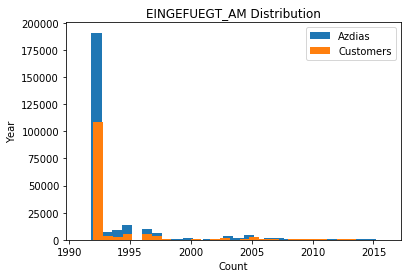

In [50]:
plt.hist(azdias["EINGEFUEGT_AM"], bins=30, label="Azdias")
plt.hist(customers["EINGEFUEGT_AM"], bins=30, label="Customers")
plt.ylabel("Year")
plt.xlabel("Count")
plt.title("EINGEFUEGT_AM Distribution")
plt.legend()
plt.show()

* The distributions are almost similar between "Azdias" and "Customers" 

* We can further analyse and change other categorical columns after making sure all the unkown values are replaced with "NaN"s 

### Addressing Unkown Values

From the information given in the attributes-values dataframe, some columns have unkown values recorded with specific representations. These unkown representations can be obtained by the following steps. We can later use these representations to change them to NaN values, by treating them as missing entries.

In [51]:
unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
print(len(unkown_attributes_values))

232


Note: we have 232 columns which have unkown values, as displayed below. These values in the columns need to be replaced with NaN values.

In [52]:
unkown_attributes_values

Attribute  \
0                        AGER_TYP   
5            ALTERSKATEGORIE_GROB   
33                      ANREDE_KZ   
40                       BALLRAUM   
48                       BIP_FLAG   
51                CAMEO_DEUG_2015   
105            CAMEO_DEUINTL_2015   
131                 CJT_GESAMTTYP   
391              D19_KK_KUNDENTYP   
647                      EWDICHTE   
654                     FINANZTYP   
661                FINANZ_ANLEGER   
667              FINANZ_HAUSBAUER   
673             FINANZ_MINIMALIST   
679                 FINANZ_SPARER   
685         FINANZ_UNAUFFAELLIGER   
691              FINANZ_VORSORGER   
697                   GEBAEUDETYP   
724                 GEOSCORE_KLS7   
734             HAUSHALTSSTRUKTUR   
744                    HEALTH_TYP   
749            HH_EINKOMMEN_SCORE   
756                    INNENSTADT   
765                  KBA05_ALTER1   
771                  KBA05_ALTER2   
777                  KBA05_ALTER3   
783                  KBA05_ALTER4   
790                  KBA05_ANHANG   
795                   KBA05_ANTG1   
801                   KBA05_ANTG2   
807                   KBA05_ANTG3   
812                   KBA05_ANTG4   
821                           NaN   
822                  KBA05_BAUMAX   
828                    KBA05_CCM1   
834                    KBA05_CCM2   
840                    KBA05_CCM3   
846                    KBA05_CCM4   
852                  KBA05_DIESEL   
858                    KBA05_FRAU   
864                     KBA05_GBZ   
870                  KBA05_HERST1   
877                  KBA05_HERST2   
884                  KBA05_HERST3   
891                  KBA05_HERST4   
898                  KBA05_HERST5   
905               KBA05_HERSTTEMP   
911                KBA05_KRSAQUOT   
917               KBA05_KRSHERST1   
923               KBA05_KRSHERST2   
929               KBA05_KRSHERST3   
935                KBA05_KRSKLEIN   
939                 KBA05_KRSOBER   
943                  KBA05_KRSVAN   
947                  KBA05_KRSZUL   
951                     KBA05_KW1   
957                     KBA05_KW2   
963                     KBA05_KW3   
969                   KBA05_MAXAH   
975                   KBA05_MAXBJ   
980                KBA05_MAXHERST   
986                  KBA05_MAXSEG   
991                 KBA05_MAXVORB   
995                    KBA05_MOD1   
1001                   KBA05_MOD2   
1007                   KBA05_MOD3   
1013                   KBA05_MOD4   
1020                   KBA05_MOD8   
1025                KBA05_MODTEMP   
1031                  KBA05_MOTOR   
1036                 KBA05_MOTRAD   
1041                   KBA05_SEG1   
1046                  KBA05_SEG10   
1052                   KBA05_SEG2   
1058                   KBA05_SEG3   
1064                   KBA05_SEG4   
1070                   KBA05_SEG5   
1076                   KBA05_SEG6   
1079                   KBA05_SEG7   
1084                   KBA05_SEG8   
1089                   KBA05_SEG9   
1094                  KBA05_VORB0   
1100                  KBA05_VORB1   
1106                  KBA05_VORB2   
1113                   KBA05_ZUL1   
1119                   KBA05_ZUL2   
1125                   KBA05_ZUL3   
1132                   KBA05_ZUL4   
1139         KBA13_ALTERHALTER_30   
1146         KBA13_ALTERHALTER_45   
1153         KBA13_ALTERHALTER_60   
1160         KBA13_ALTERHALTER_61   
1168                   KBA13_AUDI   
1175              KBA13_AUTOQUOTE   
1182                KBA13_BJ_1999   
1189                KBA13_BJ_2000   
1196                KBA13_BJ_2004   
1203                KBA13_BJ_2006   
1210                KBA13_BJ_2008   
1217                KBA13_BJ_2009   
1224                    KBA13_BMW   
1231               KBA13_CCM_1000   
1238               KBA13_CCM_1200   
1245               KBA13_CCM_1400   
1252             KBA13_CCM_0_1400   
1259               KBA13_CCM_1500   
1266          KBA13_CCM_1400_2500   
1273               KBA13_CCM

In [53]:
unkown_attributes_values = unkown_attributes_values.dropna()

In [54]:
def get_unkown_representation(attrib, unkown_attributes_values):
    """Returns the representation of unkown values"""
    
    unkown = unkown_attributes_values[unkown_attributes_values["Attribute"] == attrib]["Value"]
    unkown = unkown.astype(str).str.cat(sep=",")
    unkown = [int(x) for x in unkown.split(",")]

    return [unkown]

In [55]:
ager_typ_unknown = get_unkown_representation("AGER_TYP", unkown_attributes_values)

print(ager_typ_unknown)

[[-1]]


The second column 'AGER_TYP' has a lot of "-1"s which correspond to unkown values. To convert all these values into "np.nan" values we first have to get the value which corresponds to unkown value from the attribute_value data and then replace these values.

In [56]:
def replace_unkown_with_nan(val, unkown):
    """Replaces unkown values with np.nan values if the value mathes with the unkown representation"""
    if val in unkown:
        return np.nan
    else:
        return val

In [57]:
azdias["AGER_TYP"] = azdias["AGER_TYP"].apply(replace_unkown_with_nan, args=(ager_typ_unknown))

In [58]:
azdias

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0       910215       NaN         NaN       NaN          NaN          NaN   
1       910220       NaN         9.0       0.0          NaN          NaN   
2       910225       NaN         9.0      17.0          NaN          NaN   
3       910226       2.0         1.0      13.0          NaN          NaN   
4       910241       NaN         1.0      20.0          NaN          NaN   
...        ...       ...         ...       ...          ...          ...   
290394  531253       NaN         NaN       NaN          NaN          NaN   
290395  531261       NaN         9.0      18.0          NaN          NaN   
290396  531267       NaN         9.0      17.0          NaN          NaN   
290397  531268       NaN         1.0       0.0          NaN          NaN   
290398  723421       NaN         4.0      20.0          NaN          NaN   

        ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0               NaN          NaN                   NaN                  NaN   
1               NaN          NaN                  21.0                 11.0   
2               NaN          NaN                  17.0                 10.0   
3               NaN          NaN                  13.0                  1.0   
4               NaN          NaN                  14.0                  3.0   
...             ...          ...                   ...                  ...   
290394          NaN          NaN                   NaN                  NaN   
290395          NaN          NaN                  18.0                 17.0   
290396          NaN          NaN                  17.0                 35.0   
290397          NaN          NaN                   NaN                 35.0   
290398          NaN          NaN                  20.0                  7.0   

        ...  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0       ...       NaN         NaN      NaN             NaN             NaN   
1       ...       8.0        11.0     10.0             3.0             9.0   
2       ...       9.0         9.0      6.0             3.0             9.0   
3       ...       7.0        10.0     11.0             NaN             9.0   
4       ...       3.0         5.0      4.0             2.0             9.0   
...     ...       ...         ...      ...             ...             ...   
290394  ...       NaN         NaN      NaN             NaN             NaN   
290395  ...       8.0        10.0      7.0             6.0             9.0   
290396  ...       7.0        10.0      8.0             5.0             9.0   
290397  ...       8.0        10.0      7.0             NaN             7.0   
290398  ...       NaN         NaN      NaN             NaN             NaN   

        WOHNLAGE  ZABEOTYP ANREDE_KZ  ALTERSKATEGORIE_GROB  Temp  
0            NaN       3.0       1.0                   2.0  15.0  
1            4.0       5.0       2.0                   1.0  21.0  
2            2.0       5.0       2.0                   3.0   3.0  
3            7.0       3.0       2.0                   4.0   NaN  
4            3.0       4.0       1.0                   3.0  32.0  
...          ...       ...       ...                   ...   ...  
290394       NaN       3.0       2.0                   3.0   NaN  
290395       3.0       5.0       1.0                   2.0   1.0  
290396       4.0       5.0       1.0                   1.0   4.0  
290397       4.0       3.0       1.0                   4.0   NaN  
290398       NaN       NaN       NaN                   NaN   NaN  

[290399 rows x 367 columns]

We can repeat the same thing for all other columns with unkown values.

In [59]:
def replace_unkowns(df, unkown_attributes_values, verbose=False):
    """
    Replaces unkown values to 'np.nan' in all the columns provided in unkown_attributes_values list.
    """
    for attrib in unkown_attributes_values.Attribute:
        unkown = get_unkown_representation(attrib, unkown_attributes_values)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unkown, attrib))
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(replace_unkown_with_nan, args=(unkown))
    return df

In [60]:
azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Replacing [[-1]] to NaN in Attribute KBA13_SEG_MINIVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_MINIWAGEN
Replacing [[-1]] to NaN in Attribute KBA13

In [61]:
customers = replace_unkowns(customers, unkown_attributes_values, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP
Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1

Replacing [[-1]] to NaN in Attribute KBA13_KW_90
Replacing [[-1]] to NaN in Attribute KBA13_KW_110
Replacing [[-1]] to NaN in Attribute KBA13_KW_120
Replacing [[-1]] to NaN in Attribute KBA13_KW_121
Replacing [[-1]] to NaN in Attribute KBA13_MAZDA
Replacing [[-1]] to NaN in Attribute KBA13_MERCEDES
Replacing [[-1]] to NaN in Attribute KBA13_MOTOR
Replacing [[-1]] to NaN in Attribute KBA13_NISSAN
Replacing [[-1]] to NaN in Attribute KBA13_OPEL
Replacing [[-1]] to NaN in Attribute KBA13_PEUGEOT
Replacing [[-1]] to NaN in Attribute KBA13_RENAULT
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GELAENDEWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_GROSSRAUMVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINST
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KLEINWAGEN
Replacing [[-1]] to NaN in Attribute KBA13_SEG_KOMPAKTKLASSE
Replacing [[-1]] to NaN in Attribute KBA13_SEG_MINIVANS
Replacing [[-1]] to NaN in Attribute KBA13_SEG_MINIWAGEN
Replacing [[-1]] to NaN in Attribute KBA13

### Missing Values

Now that we have replaced all the unkowns to np.nan, so we can now look at how many missing values in each column and then decide whether to keep the column for further analysis.

#### Missing values Column-wise

In [62]:
def get_missing_report(df):
    """
    Takes in a dataframe and returns a dataframe with information about column-wise missing values percentages.
    """
    missing_percen = df.isna().sum() * 100/ len(df)
    
    missing_percen_df = pd.DataFrame({"Attribute": df.columns,
                                     "Missing_Percentage": missing_percen}).reset_index(drop=True)
    return missing_percen_df

In [63]:
customer_missing_report = get_missing_report(customers)
azdias_missing_report = get_missing_report(azdias)

In [64]:
print("Total Number of columns in Customers - ", len(customers.columns))
print("Number of columns with missing values in customers - ",
      len(customer_missing_report[customer_missing_report.Missing_Percentage > 0]))

print("Total Number of columns in Azdias - ", len(azdias.columns))
print("Number of columns with missing values in azdias - ",
      len(azdias_missing_report[azdias_missing_report.Missing_Percentage > 0]))

Total Number of columns in Customers -  370
Number of columns with missing values in customers -  280
Total Number of columns in Azdias -  367
Number of columns with missing values in azdias -  304


In [65]:
def plot_percentage_missing(df1, df2, percentage=0, figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Data percentages")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df1[df1.Missing_Percentage>percentage], ax= ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing_Percentage", 
                data=df2[df2.Missing_Percentage>percentage], ax= ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    # fig.tight_layout()
    plt.show()

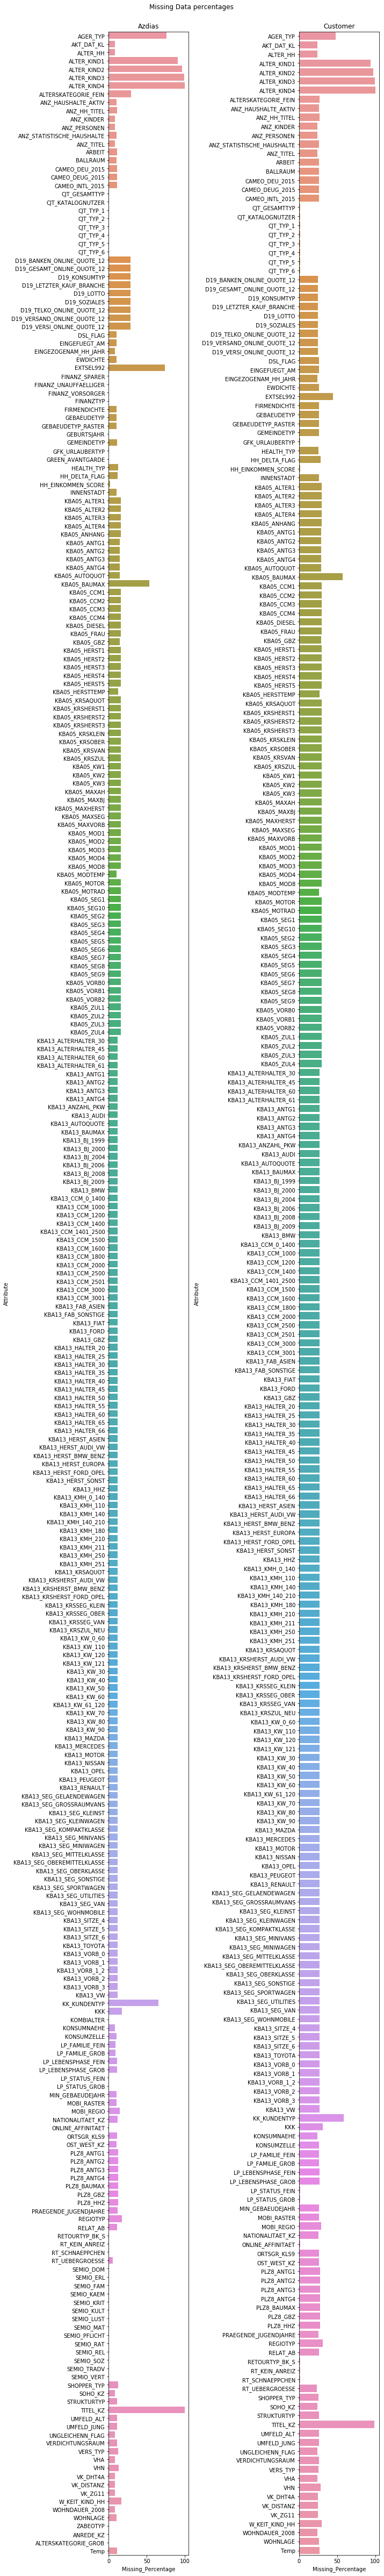

In [66]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=0)

Note: 

* There is overlap in both Azdias and Customers dataset i.e. data is missing from same columns.
* We now can threshold the missing percentage as 30 and see how many columns have missing data percentage more than the threshold.

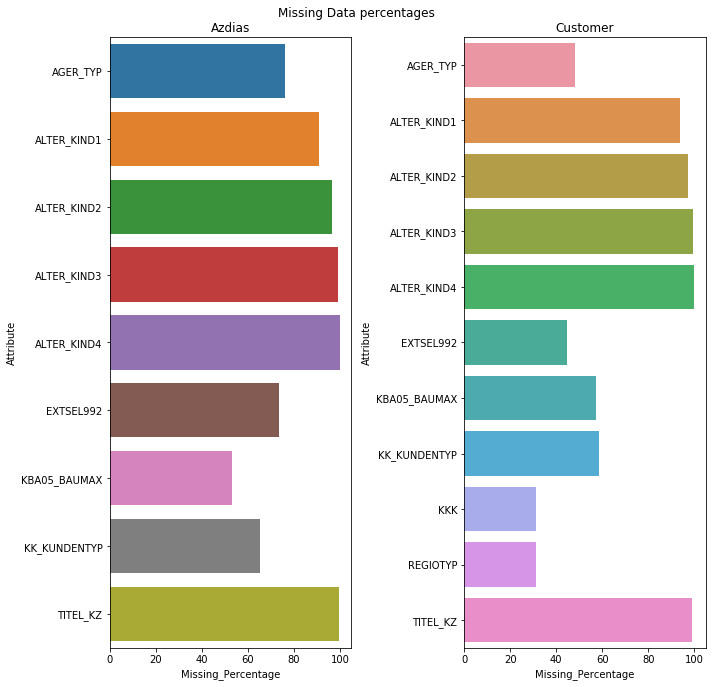

In [67]:
plot_percentage_missing(azdias_missing_report, customer_missing_report, percentage=30, figsize=(10, 10))

By observing th plot: 

* We have 11 features with more more than 30% missing values in Customer data, where as in Azdias data we only have 9 feature. However, in total we had 279 columns with missing values in both dataframes.
* So 11 and 9 are considerably less number of features when compared to 279 so we can drop them.
* The next step is to remove the features with more than 30% of data from Customer dataset, also the same features have to be removed from Azdias dataset.

In [68]:
def remove_columns(df, remove_cols):
    """
    Drops given list of columns from df.
    """
    df = df.drop(remove_cols, axis = 1)
    return df

def remove_missing_columns(df1, df2, df1_missing, df2_missing, threshold=30):
    """
    Drops columns from df1 and df2 with given threshold.
    
    Uses df1_missing and df2_missing to determing which columns to remove.
    If df1_missing has more missing columns (missing_percentage > threshold),
    then df1_missing is taken as reference and vice versa.
    """
    
    removable_cols1 = df1_missing[df1_missing.Missing_Percentage > threshold]
    removable_cols2 = df2_missing[df2_missing.Missing_Percentage > threshold]
    
    if len(removable_cols1) > len(removable_cols2):
        remove_cols = removable_cols1.Attribute.tolist()
    else:
        remove_cols = removable_cols2.Attribute.tolist()
         
    df1 = remove_columns(df1, remove_cols)
    df2 = remove_columns(df2, remove_cols)
    print(f"\t\tRemoved {len(remove_cols)} columns from given dataframes")
    
    return (df1, df2, remove_cols)

In [69]:
print("Number of columns Before dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

azdias, customers, removed_cols = remove_missing_columns(azdias, customers, customer_missing_report, azdias_missing_report)

print("Number of columns After dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns Before dropping
Azdias - 367
Customers - 370
		Removed 11 columns from given dataframes
Number of columns After dropping
Azdias - 356
Customers - 359


### Missing values Row-wise

After removing the columns which have more than 30% missing values, now we can look at the dataframes with remaining features for any missing values in rows.

In [70]:
def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Rows vs No. of Missing features")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()

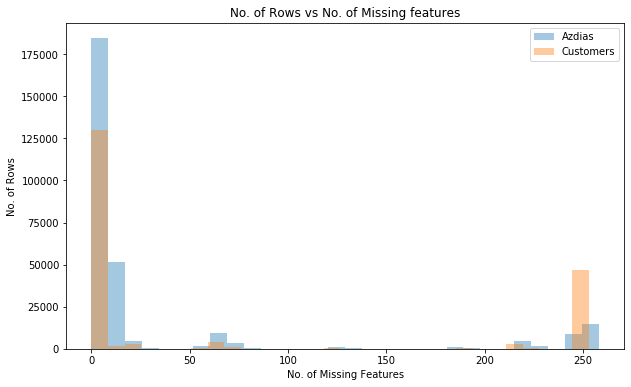

In [71]:
plot_missing_rowwise_histogram(azdias, customers)

Note: 

* Most of the rows have only a few missing values in both dataframes.
* Customers data has comparatively less missing rows than Azdias.
* We can drop all the rows which have more than 50 missing values.

In [72]:
def remove_missing_rows(df, threshold, name=""):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    print(f"\t\tRemoved {removed_rows} rows from {name} dataframe")
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [73]:
print("Number of rows Before dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

print("Number of rows After dropping")
print(f"Azdias - {len(azdias)}")
print(f"Customers - {len(customers)}")

Number of rows Before dropping
Azdias - 290399
Customers - 191652
		Removed 57406 rows from  dataframe
		Removed 49285 rows from  dataframe
Number of rows After dropping
Azdias - 241114
Customers - 134246


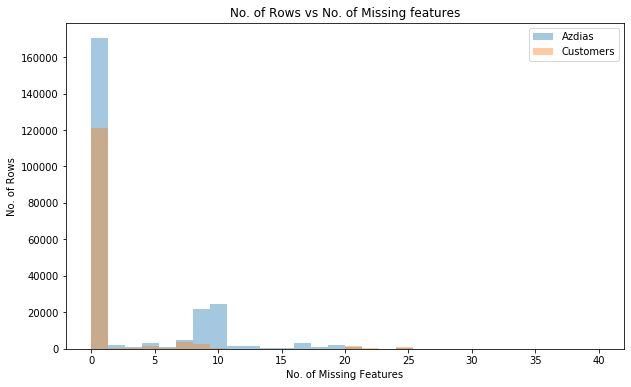

In [71]:
plot_missing_rowwise_histogram(azdias, customers)

As seen in the above plot we have successfully removed all the rows having more than 50 missing features. But, we still have some missing values in range of 1 to 50. We can impute most common values of corresponding features in these rows, as the data represents the demographics of population. We can make an assumption that these missing values will be equal to the most common ones.

# Part 2: Data Preprocessing (categorical data re-encoding and data scaling)

### Column Types

In [74]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241114 entries, 0 to 241113
Columns: 356 entries, LNR to Temp
dtypes: float64(290), int64(63), object(3)
memory usage: 654.9+ MB


In [75]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134246 entries, 0 to 134245
Columns: 359 entries, LNR to Temp
dtypes: float64(266), int64(88), object(5)
memory usage: 367.7+ MB


There are three and five columns with dtype - object in azdias and customers datasets, respectively, we can look at the unique values in these columns.

In [76]:
azdias_object_cols = azdias.columns[azdias.dtypes == "object"]
customer_object_cols = customers.columns[customers.dtypes == "object"]

In [77]:
print("Azdias columns with dtype Object \n",azdias_object_cols.values)
print("Customer columns with dtype Object \n",customer_object_cols.values)

Azdias columns with dtype Object 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ']
Customer columns with dtype Object 
 ['CAMEO_DEU_2015' 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ' 'PRODUCT_GROUP'
 'CUSTOMER_GROUP']


In [78]:
for col in azdias_object_cols:
    print("\nColumn ",col)
    print(azdias[col].value_counts())


Column  CAMEO_DEU_2015
6B    17846
8A    16607
4C    14461
3C    10900
2D    10836
7A    10726
3D    10308
8B    10167
4A    10123
8C     9682
9D     8773
9B     8163
7B     7489
9C     7478
9A     6543
2C     5763
8D     5263
6E     4915
5D     4603
2B     4568
6C     4544
2A     3987
1D     3821
1A     3339
5B     3309
5A     3184
5C     2978
4B     2755
7C     2726
4D     2580
6A     2074
3B     1944
3A     1920
6D     1842
6F     1668
4E     1651
1E     1531
7D     1509
7E     1362
1C     1327
1B     1294
5F     1264
9E     1238
5E     1069
XX       86
Name: CAMEO_DEU_2015, dtype: int64

Column  D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT             58575
D19_VERSICHERUNGEN        17006
D19_SONSTIGE              13449
D19_VOLLSORTIMENT         10283
D19_SCHUHE                 9354
D19_BUCH_CD                8311
D19_VERSAND_REST           7671
D19_DROGERIEARTIKEL        7014
D19_BANKEN_DIREKT          6823
D19_BEKLEIDUNG_REST        6267
D19_HAUS_DEKO              6051
D19_TELKO_MOBIL

Note: OST_WEST_KZ - contains information about the history of the person i.e. which part of Germany they belonged to before unification. We can encode values in this column with pd_dummies or a label encoder.

The columns that can be removed as they have too much granularity in information they represent. This will increase the number of features for modeling purposes. So these columns can also be dropped for simplicity:
* D19_LETZTER_KAUF_BRANCHE - contains information about the last branch they made a purchase.
* CAMEO_DEU_2015 - Gives information about specific group a person belongs to.

In [79]:
remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]

azdias = remove_columns(azdias, remove_extra_cols)
customers = remove_columns(customers, remove_extra_cols)

### Encoding Categorical Columns

* Encoding OST_WEST_KZ column

In [80]:
def fix_ost_west_col(df):
    """
    Function to label encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    return df

In [81]:
azdias = fix_ost_west_col(azdias)
customers = fix_ost_west_col(customers)

Ecoding ANREDE_KZ column

In [82]:
def fix_anrede_col(df):
    """
    Function to label encode the feature "ANREDE_KZ"
    """
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    
    return df

In [83]:
azdias = fix_anrede_col(azdias)
customers = fix_anrede_col(customers)

Encoding CAMEO_INTL_2015 column

In [84]:
azdias['CAMEO_INTL_2015'].unique()

array([51., 24., 12., 43., 54., 22., 14., 13., 15., 41., 34., 55., 33.,
       25., nan, 23., 31., 52., 45., 35., 44., 32.])

In [85]:
customers['CAMEO_INTL_2015'].unique()

array([13., 34., 24., 41., 23., 15., 55., 14., 22., 51., 43., 33., 25.,
       44., 54., 32., 12., 35., 31., 45., 52., nan])

In [86]:
def fix_cameo_intl_col(df):
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    return df

In [87]:
azdias = fix_cameo_intl_col(azdias)
customers = fix_cameo_intl_col(customers)

In [88]:
azdias['CAMEO_INTL_2015_FAMILY'].unique()

array([ 1.,  4.,  2.,  3.,  5., nan])

In [89]:
azdias['CAMEO_INTL_2015_WEALTH'].unique()

array([ 5.,  2.,  1.,  4.,  3., nan])

Fixing WOHNLAGE column: the column WOHNLAGE contains value - 0 for - no score calculated, while all other values represent some score. This value can be replaced with NaN.

In [90]:
azdias.WOHNLAGE.value_counts()

3.0    76244
7.0    52509
4.0    41966
2.0    31482
5.0    22247
1.0    13704
8.0     2957
0.0        5
Name: WOHNLAGE, dtype: int64

In [91]:
def fix_wohnlage_col(df):
    """
    Function to remove '0' from "WOHNLAGE" 
    """
    df["WOHNLAGE"] = df["WOHNLAGE"].replace({0: np.nan})
    
    return df

In [92]:
azdias = fix_wohnlage_col(azdias)
customers = fix_wohnlage_col(customers)

Seperating customers dataframe into two parts, i.e. taking out the extra columns present in customers dataset as a separate dataframe.

In [93]:
customer_extra_cols = customers[extra_cols_in_customers]
customers = customers.drop(extra_cols_in_customers, axis = 1)

In [94]:
customer_extra_cols

PRODUCT_GROUP CUSTOMER_GROUP  ONLINE_PURCHASE
0       COSMETIC_AND_FOOD    MULTI_BUYER                0
1       COSMETIC_AND_FOOD    MULTI_BUYER                0
2                COSMETIC    MULTI_BUYER                0
3                    FOOD    MULTI_BUYER                0
4       COSMETIC_AND_FOOD    MULTI_BUYER                0
...                   ...            ...              ...
134241  COSMETIC_AND_FOOD    MULTI_BUYER                0
134242           COSMETIC   SINGLE_BUYER                0
134243  COSMETIC_AND_FOOD    MULTI_BUYER                0
134244               FOOD   SINGLE_BUYER                0
134245  COSMETIC_AND_FOOD    MULTI_BUYER                0

[134246 rows x 3 columns]

Finally checking the shapes of all the dataframes.

In [95]:
azdias.shape, customers.shape, customer_extra_cols.shape

((241114, 353), (134246, 353), (134246, 3))

## Imputing missing values

Although we dropped columns and rows with missing values based on some threshold. We still have some columns having missing values. We can now address these missing values by either filling them with the mean of the values or most common values.

In this case, imputing missing values with most common values will make sense as this is demographic data and the values that are most common represent the population.

In [96]:
azdias.isna().sum()

LNR                                0
AKT_DAT_KL                         0
ALTER_HH                           0
ALTERSKATEGORIE_FEIN           54890
ANZ_HAUSHALTE_AKTIV                0
ANZ_HH_TITEL                    1090
ANZ_KINDER                         0
ANZ_PERSONEN                       0
ANZ_STATISTISCHE_HAUSHALTE         0
ANZ_TITEL                          0
ARBEIT                          1287
BALLRAUM                         127
CAMEO_DEUG_2015                  984
CJT_GESAMTTYP                   1458
CJT_KATALOGNUTZER               1458
CJT_TYP_1                       1458
CJT_TYP_2                       1458
CJT_TYP_3                       1458
CJT_TYP_4                       1458
CJT_TYP_5                       1458
CJT_TYP_6                       1458
D19_BANKEN_ANZ_12                  0
D19_BANKEN_ANZ_24                  0
D19_BANKEN_DATUM                   0
D19_BANKEN_DIREKT                  0
D19_BANKEN_GROSS                   0
D19_BANKEN_LOKAL                   0
D

In [97]:
customers.isna().sum()

LNR                               0
AKT_DAT_KL                        0
ALTER_HH                          0
ALTERSKATEGORIE_FEIN           4493
ANZ_HAUSHALTE_AKTIV               0
ANZ_HH_TITEL                   2025
ANZ_KINDER                        0
ANZ_PERSONEN                      0
ANZ_STATISTISCHE_HAUSHALTE        0
ANZ_TITEL                         0
ARBEIT                          521
BALLRAUM                         26
CAMEO_DEUG_2015                 300
CJT_GESAMTTYP                  3026
CJT_KATALOGNUTZER              3026
CJT_TYP_1                      3026
CJT_TYP_2                      3026
CJT_TYP_3                      3026
CJT_TYP_4                      3026
CJT_TYP_5                      3026
CJT_TYP_6                      3026
D19_BANKEN_ANZ_12                 0
D19_BANKEN_ANZ_24                 0
D19_BANKEN_DATUM                  0
D19_BANKEN_DIREKT                 0
D19_BANKEN_GROSS                  0
D19_BANKEN_LOKAL                  0
D19_BANKEN_OFFLINE_DATUM    

In [98]:
customer_extra_cols.isna().sum()

PRODUCT_GROUP      0
CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
dtype: int64

In [99]:
imputer = SimpleImputer(strategy="most_frequent")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [100]:
azdias.shape, customers.shape, customer_extra_cols.shape

((241114, 353), (134246, 353), (134246, 3))

## Data Cleaning function

All the above data cleaning steps could be organized into one single function before proceeding to further steps.  We could load the raw data into this function for data cleaning with full replication. 

In [101]:
def load_raw():
    # Reload attribute values but ignoring "Unnamed" column 
    no_unamed = lambda x: 'Unnamed' not in x
    attributes_values = pd.read_excel('./data/Input/DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
    attributes_info = pd.read_excel('./data/Input/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)
    azdias = pd.read_csv('./data/Input/Udacity_AZDIAS_052018.csv', sep=';', usecols=no_unamed)
    customers = pd.read_csv('./data/Input/Udacity_CUSTOMERS_052018.csv', sep=';',usecols=no_unamed)
    return attributes_values, attributes_info, azdias, customers

In [102]:
def clean_data(azdias, customers, attributes_values, column_miss_perc=30, row_miss_count=50):
    
    print("Cleaning in Progress...")
    
    start = time.time()
    
    cleaning_info = {}
    
    extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
    
    # Forward fill attribute_values dataframe, to access required columns and corresponding info
    #attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(azdias.columns[18:20])
    
    customers = change_cameo_cols(customers)
    azdias = change_cameo_cols(azdias)
        
        
    print("\tFixing LP_* columns")
    customers = restructure_LP_cols(customers)
    azdias = restructure_LP_cols(azdias)
    
    print("\tFixing EINGEFUGT column")
    customers = change_eigefugt_col(customers)
    azdias = change_eigefugt_col(azdias)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"].dropna()
    
    azdias = replace_unkowns(azdias, unkown_attributes_values, verbose=False)
    customers = replace_unkowns(customers, unkown_attributes_values, verbose=False)
    
    # Missing Values
    
    # Columns with missing values
    print(f"\tRemoving columns with more than {column_miss_perc} % missing values")
    customer_missing_report = get_missing_report(customers)
    azdias_missing_report = get_missing_report(azdias)
    
    azdias, customers, removed_cols = remove_missing_columns(azdias, customers, 
                                               customer_missing_report,
                                               azdias_missing_report,
                                              threshold=column_miss_perc)
    
    
    
    # Rows with missing values
    print(f"\tRemoving rows with more than {row_miss_count} missing values")
    customers = remove_missing_rows(customers, threshold=row_miss_count, name="Customers")
    azdias = remove_missing_rows(azdias, threshold=row_miss_count, name="Azdias")
    
    
    # Columns with no relevant information of which are too granular
    print("\tRemoving unwanted Columns")
    remove_extra_cols = ["D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]
    removed_cols += remove_extra_cols
         
    azdias = remove_columns(azdias, remove_extra_cols)
    customers = remove_columns(customers, remove_extra_cols)
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding OST_WEST_KZ column")
    azdias = fix_ost_west_col(azdias)
    customers = fix_ost_west_col(customers)
    
    print("\tEncoding ANREDE Column")
    azdias = fix_anrede_col(azdias)
    customers = fix_anrede_col(customers)
    
    print("\tEncoding CAMEO_INT column")
    azdias = fix_cameo_intl_col(azdias)
    customers = fix_cameo_intl_col(customers)
    
    print("\tEncoding WOHNLAGE column")
    azdias = fix_wohnlage_col(azdias)
    customers = fix_wohnlage_col(customers)
    
    # Separating customers dataset
    customers_additional = customers[extra_cols_in_customers]
    customers = customers.drop(extra_cols_in_customers, axis = 1)
        
    
    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="most_frequent")

    azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
    customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)
    
    
    cleaning_info["Removed_cols"] = removed_cols   
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return azdias, customers, customers_additional, cleaning_info

In [103]:
# Check for these two functions
attributes_values, attributes_info, azdias, customers = load_raw()
azdias_cleaned, customers_cleaned, customers_additional_cleaned, cleaning_info = clean_data(azdias, customers, attributes_values, column_miss_perc=30, row_miss_count=50)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Cleaning in Progress...
	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Removing columns with more than 30 % missing values
		Removed 11 columns from given dataframes
	Removing rows with more than 50 missing values
		Removed 57406 rows from Customers dataframe
		Removed 49285 rows from Azdias dataframe
	Removing unwanted Columns
	Encoding OST_WEST_KZ column
	Encoding ANREDE Column
	Encoding CAMEO_INT column
	Encoding WOHNLAGE column
	Imputing missing values with most frequent ones
Completed Cleaning in 71.16008996963501 seconds


In [104]:
# Sanitory check 
azdias_cleaned.shape, customers_cleaned.shape, customers_additional_cleaned.shape

((241114, 353), (134246, 353), (134246, 3))

# Save data to local files

In [105]:
files_cleaned_dir = 'data/cleaned'

if not os.path.exists(files_cleaned_dir):
    os.makedirs(files_cleaned_dir)
    
azdias_cleaned.to_csv('./data/cleaned/Azdias_cleaned.csv', index=False)
customers_cleaned.to_csv('./data/cleaned/Customers_cleaned.csv', index=False)
customers_additional_cleaned.to_csv('./data/cleaned/Customer_Additional_cleaned.csv', index=False)

In [106]:
def load_cleaned(): 
    attributes_values = pd.read_excel('./data/Input/DIAS Attributes - Values 2017.xlsx', header=1)
    attributes_info = pd.read_excel('./data/Input/DIAS Information Levels - Attributes 2017.xlsx', header=1)
    azdias = pd.read_csv('./data/cleaned/Azdias_cleaned.csv', sep=',')
    customers = pd.read_csv('./data/cleaned/Customers_cleaned.csv', sep=',')
    customers_additional = pd.read_csv('./data/cleaned/Customer_Additional_cleaned.csv', sep=',')
    return attributes_values, attributes_info, azdias, customers, customers_additional

In [107]:
attributes_attributes, attributes_info, azdias_cleaned, customers_cleaned, customers_additional_cleaned = load_cleaned()

In [108]:
# Sanitory check 
azdias_cleaned.shape, customers_cleaned.shape, customers_additional_cleaned.shape

((241114, 353), (134246, 353), (134246, 3))

Column LNR corresponds to id of each person and not a feature. We can drop this column for further analysis. 

In [109]:
azdias_cleaned = azdias_cleaned.drop("LNR", axis=1)
customers_cleaned = customers_cleaned.drop("LNR", axis=1)

## Feature Scaling 

* Standardizing the scale of the numerical columns in order to consistently compare the values of different features. We will use a StandardScaler to transform the numerical values so that they have the same range.

In [110]:
# scale numerical features 
scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns = azdias_cleaned.columns, index = azdias_cleaned.index)
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_cleaned), columns = customers_cleaned.columns, index = customers_cleaned.index)

In [111]:
azdias_scaled

AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0         1.259814 -1.434149              1.561893             0.190422   
1         1.259814  0.797345              0.673033             0.123911   
2        -0.936226  0.272287             -0.215827            -0.474689   
3        -0.936226  1.191138              0.006388            -0.341667   
4        -0.936226 -0.121506             -0.882472            -0.208645   
...            ...       ...                   ...                  ...   
241109   -0.936226 -1.434149              0.228603             1.387624   
241110    0.161794 -1.434149              0.228603            -0.142133   
241111    1.259814  0.928609              0.895248             0.589489   
241112    1.259814  0.797345              0.673033             1.786691   
241113   -0.936226 -1.434149              0.228603             1.786691   

        ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0          -0.124437   -0.301247      0.218853                    0.342117   
1          -0.124437   -0.301247     -0.633778                   -0.028879   
2          -0.124437   -0.301247     -1.486409                   -0.399876   
3          -0.124437   -0.301247      1.924115                   -0.325676   
4          -0.124437   -0.301247     -0.633778                   -0.399876   
...              ...         ...           ...                         ...   
241109     -0.124437   -0.301247     -0.633778                    1.232508   
241110     -0.124437   -0.301247     -0.633778                   -0.177278   
241111     -0.124437   -0.301247     -0.633778                    0.935711   
241112     -0.124437   -0.301247     -0.633778                    1.974500   
241113     -0.124437   -0.301247     -1.486409                    1.974500   

        ANZ_TITEL    ARBEIT  ...   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0       -0.060155 -0.158990  ...  1.444672       -0.741360        0.548627   
1       -0.060155 -0.158990  ...  0.012817       -0.741360        0.548627   
2       -0.060155 -1.161990  ...  1.802635        0.955435        0.548627   
3       -0.060155  0.844011  ... -0.703111       -1.306958        0.548627   
4       -0.060155 -1.161990  ... -0.703111        0.955435        0.548627   
...           ...       ...  ...       ...             ...             ...   
241109  -0.060155 -1.161990  ...  0.370781        0.389837       -1.039471   
241110  -0.060155  0.844011  ...  0.728744       -0.175762       -2.627569   
241111  -0.060155  0.844011  ...  0.370781        0.955435        0.548627   
241112  -0.060155 -0.158990  ...  0.728744        0.389837        0.548627   
241113  -0.060155 -0.158990  ...  0.370781        0.955435       -0.510105   

        WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB      Temp  \
0      -0.024663  1.145195   0.956843             -1.676427  0.448662   
1      -1.079293  1.145195   0.956843              0.168611 -0.993454   
2       1.557283 -0.274060   0.956843              1.091130 -1.153689   
3      -0.551978  0.435567  -1.045103              0.168611  1.329955   
4       1.557283  0.435567   0.956843             -1.676427 -0.592866   
...          ...       ...        ...                   ...       ...   
241109 -0.551978 -0.274060  -1.045103              0.168611 -0.833218   
241110 -1.079293 -0.274060   0.956843              0.168611 -0.672983   
241111 -0.551978  1.145195  -1.045103             -0.753908 -1.153689   
241112 -0.024663  1.145195  -1.045103             -1.676427 -0.913336   
241113 -0.024663 -0.274060  -1.045103              1.091130 -1.153689   

        CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_FAMILY  
0                     1.174229               -1.250353  
1                    -0.871690                0.768488  
2                    -1.553663               -0.577406  
3                     0.492256                0.095541  
4                     1.174229                0.768488  
...           

In [112]:
customers_scaled

AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0        -0.367858 -0.216129             -0.100224            -0.274802   
1        -0.367858 -0.855203             -2.529358            -0.274802   
2        -0.367858 -0.535666             -0.586051            -0.347719   
3        -0.367858  1.381556              0.871429             0.162700   
4        -0.367858 -0.056360             -0.100224            -0.274802   
...            ...       ...                   ...                  ...   
134241   -0.367858 -0.375897             -0.343138            -0.274802   
134242    0.155422 -1.813814             -2.529358            -0.347719   
134243   -0.367858  0.582714             -0.100224            -0.274802   
134244   -0.367858  0.263177              0.628516            -0.056051   
134245   -0.367858 -1.813814             -0.343138            -0.274802   

        ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           -0.12496   -0.265318     -0.207283                   -0.257866   
1           -0.12496   -0.265318     -0.921821                   -0.257866   
2           -0.12496   -0.265318     -1.636359                   -0.257866   
3           -0.12496   -0.265318      1.221792                    0.185989   
4           -0.12496   -0.265318     -0.207283                   -0.257866   
...              ...         ...           ...                         ...   
134241      -0.12496   -0.265318     -0.921821                   -0.257866   
134242      -0.12496   -0.265318     -1.636359                   -0.257866   
134243      -0.12496   -0.265318      0.507254                   -0.257866   
134244      -0.12496   -0.265318      1.221792                   -0.109914   
134245      -0.12496   -0.265318      0.507254                   -0.257866   

        ANZ_TITEL    ARBEIT  ...   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0       -0.134726 -1.813374  ... -0.512591        0.867545        0.273904   
1       -0.134726  0.164231  ...  3.420572        0.867545        0.273904   
2       -0.134726 -1.813374  ... -0.512591        0.867545        0.273904   
3       -0.134726  0.164231  ...  0.361445       -1.281187        0.273904   
4       -0.134726  0.164231  ... -0.949609        0.867545        0.273904   
...           ...       ...  ...       ...             ...             ...   
134241  -0.134726  0.164231  ...  0.798463        0.867545        0.273904   
134242  -0.134726 -1.813374  ...  0.361445        0.867545        0.273904   
134243  -0.134726  0.164231  ...  0.798463       -0.744004        0.273904   
134244  -0.134726  0.164231  ... -0.949609       -0.206821        0.273904   
134245  -0.134726 -1.813374  ... -0.949609       -0.744004        0.273904   

        WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB      Temp  \
0       1.583686  0.462491  -0.699527              0.651177 -0.214573   
1      -0.836801  0.462491   1.429537              0.651177 -0.740635   
2       1.583686 -1.073113  -0.699527              0.651177 -1.642455   
3      -0.352704 -1.073113  -0.699527             -0.670733  0.612095   
4      -1.320899 -0.305311  -0.699527             -0.670733 -0.440028   
...          ...       ...        ...                   ...       ...   
134241 -1.320899  0.462491  -0.699527             -0.670733 -1.041241   
134242 -0.352704  0.462491   1.429537              0.651177 -1.642455   
134243 -0.352704  0.462491  -0.699527              0.651177  1.288460   
134244 -0.836801  0.462491   1.429537             -0.670733  0.687247   
134245  1.583686 -1.073113  -0.699527             -1.992643  1.138157   

        CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_FAMILY  
0                    -1.132524               -0.273513  
1                     0.287206                0.470972  
2                    -0.422659                0.470972  
3                     0.997072               -1.762483  
4                     0.287206                0.470972  
...           

### Save scaled data to a local directory and load them

In [113]:
#files_scaled_dir = 'data/scaled_raw'

#if not os.path.exists(files_scaled_dir):
#    os.makedirs(files_scaled_dir)
    
#azdias_scaled.to_csv('./data/scaled_raw/Azdias_scaled.csv', index=False)
#customers_scaled.to_csv('./data/scaled_raw/Customers_scaled.csv', index=False)

In [114]:
def load_scaled_raw(): 
    azdias = pd.read_csv('./data/scaled_raw/Azdias_scaled.csv', sep=',')
    customers = pd.read_csv('./data/scaled_raw/Customers_scaled.csv', sep=',')
    return azdias, customers

In [115]:
azdias_scaled, customers_scaled = load_scaled_raw()

In [116]:
# Sanitory check 
azdias_scaled.shape, customers_scaled.shape

((241114, 352), (134246, 352))

# Part 3: Data Preprocessing/Feature Engineering for Mailout Dataset

By now We have targeted which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model using supervised algorithm. Each row in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 \000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Mailout training dataset

In [117]:
mailout_train = pd.read_csv('./data/Input/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [118]:
mailout_train.shape

(42962, 367)

In [119]:
mailout_train.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763         2         1.0       8.0          NaN          NaN   
1  1771         1         4.0      13.0          NaN          NaN   
2  1776         1         1.0       9.0          NaN          NaN   
3  1460         2         1.0       6.0          NaN          NaN   
4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   8.0                 15.0  ...   
1          NaN          NaN                  13.0                  1.0  ...   
2          NaN          NaN                   7.0                  0.0  ...   
3          NaN          NaN                   6.0                  4.0  ...   
4          NaN          NaN                   9.0                 53.0  ...   

   VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0       5.0         2.0      1.0             6.0             9.0       3.0   
1       1.0         2.0      1.0             4.0             9.0       7.0   
2       6.0         4.0      2.0             NaN             9.0       2.0   
3       8.0        11.0     11.0             6.0             9.0       1.0   
4       2.0         2.0      1.0             6.0             9.0       3.0   

   ZABEOTYP RESPONSE ANREDE_KZ ALTERSKATEGORIE_GROB  
0         3        0         2                    4  
1         1        0         2                    3  
2         3        0         1                    4  
3         3        0         2                    4  
4         3        0         1                    3  

[5 rows x 367 columns]

0    42430
1      532
Name: RESPONSE, dtype: int64


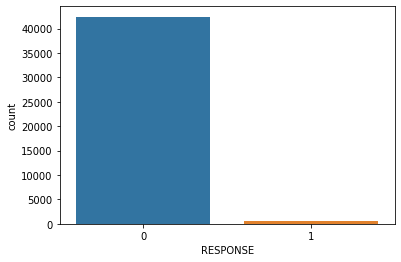

In [120]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train)

In [121]:
azdias_scaled.shape

(241114, 352)

In [122]:
azdias_list = list(azdias_scaled.columns)
mailout_train_list = list(mailout_train.columns)

In [123]:
diff = set(mailout_train_list) - set(azdias_list)
diff

{'AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KKK',
 'KK_KUNDENTYP',
 'LNR',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'REGIOTYP',
 'RESPONSE',
 'TITEL_KZ'}

In [124]:
len(diff)

18

In [125]:
common_list = set(mailout_train_list) & set(azdias_list)
common_list                               

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KIND

In [126]:
len(common_list)

349

In [127]:
set(mailout_train_list) - set(common_list)

{'AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KKK',
 'KK_KUNDENTYP',
 'LNR',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'REGIOTYP',
 'RESPONSE',
 'TITEL_KZ'}

In [128]:
set(azdias_list) - set(common_list)

{'CAMEO_INTL_2015_FAMILY', 'CAMEO_INTL_2015_WEALTH', 'Temp'}

In [129]:
labels = mailout_train["RESPONSE"]
mailout_train_LNR = mailout_train["LNR"]

In [130]:
labels

0        0
1        0
2        0
3        0
4        0
        ..
42957    0
42958    0
42959    0
42960    0
42961    0
Name: RESPONSE, Length: 42962, dtype: int64

In [131]:
mailout_train_LNR

0         1763
1         1771
2         1776
3         1460
4         1783
         ...  
42957    66338
42958    67629
42959    68273
42960    68581
42961    69224
Name: LNR, Length: 42962, dtype: int64

In [132]:
def restructure_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

In [133]:
df = restructure_LP_cols(mailout_train)

In [134]:
def change_eigefugt_col(df):
    
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

In [135]:
df = change_eigefugt_col(df)

In [136]:
df['CAMEO_INTL_2015'].unique()

array([34.0, 32.0, 14.0, 41.0, 24.0, 33.0, nan, 25.0, 31.0, 22.0, 43.0,
       13.0, 55.0, 23.0, 54.0, 51.0, 45.0, 12.0, 44.0, 35.0, 15.0, 52.0,
       '23', '44', '14', '55', '51', '45', '43', '22', '54', '24', '25',
       '13', '12', '35', '33', '41', '15', '52', '31', '32', '34', 'XX'],
      dtype=object)

In [137]:
def change_cameo_cols(df):
    """
    A function to replace 'X', 'XX' with 'np.nan' in 
    columns 18 and 19 ('CAMEO_DEUG_2015', 'CAMEO_INTL_2015') and 
    convert data types to integers    
    """
    cols = ['CAMEO_DEUG_2015','CAMEO_INTL_2015']
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    
    return df

In [138]:
df['CAMEO_DEUG_2015'].unique()

array([5.0, 2.0, 7.0, 4.0, nan, 3.0, 6.0, 1.0, 8.0, 9.0, '4', '6', '2',
       '9', '8', '7', '3', '1', '5', 'X'], dtype=object)

In [139]:
df = change_cameo_cols(df)
df

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0       1763         2         1.0       8.0          NaN          NaN   
1       1771         1         4.0      13.0          NaN          NaN   
2       1776         1         1.0       9.0          NaN          NaN   
3       1460         2         1.0       6.0          NaN          NaN   
4       1783         2         1.0       9.0          NaN          NaN   
...      ...       ...         ...       ...          ...          ...   
42957  66338         2         1.0       0.0          NaN          NaN   
42958  67629        -1         1.0       0.0          NaN          NaN   
42959  68273         1         1.0      16.0          NaN          NaN   
42960  68581         2         1.0      18.0          NaN          NaN   
42961  69224         2         1.0      13.0          NaN          NaN   

       ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0              NaN          NaN                   8.0                 15.0   
1              NaN          NaN                  13.0                  1.0   
2              NaN          NaN                   7.0                  0.0   
3              NaN          NaN                   6.0                  4.0   
4              NaN          NaN                   9.0                 53.0   
...            ...          ...                   ...                  ...   
42957          NaN          NaN                  10.0                  1.0   
42958          NaN          NaN                  14.0                  1.0   
42959          NaN          NaN                  10.0                  2.0   
42960          NaN          NaN                  13.0                  3.0   
42961          NaN          NaN                   9.0                  3.0   

       ...  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0      ...         2.0      1.0             6.0             9.0       3.0   
1      ...         2.0      1.0             4.0             9.0       7.0   
2      ...         4.0      2.0             NaN             9.0       2.0   
3      ...        11.0     11.0             6.0             9.0       1.0   
4      ...         2.0      1.0             6.0             9.0       3.0   
...    ...         ...      ...             ...             ...       ...   
42957  ...         1.0      1.0             4.0             8.0       7.0   
42958  ...         1.0      1.0             5.0             9.0       7.0   
42959  ...         2.0      1.0             2.0             9.0       7.0   
42960  ...         3.0      4.0             2.0             9.0       2.0   
42961  ...         7.0      4.0             6.0             9.0       7.0   

       ZABEOTYP  RESPONSE ANREDE_KZ  ALTERSKATEGORIE_GROB  Temp  
0             3         0         2                     4   8.0  
1             1         0         2                     3  19.0  
2             3         0         1                     4   NaN  
3             3         0         2                     4  16.0  
4             3         0         1                     3   9.0  
...         ...       ...       ...                   ...   ...  
42957         1         0         1                     4  40.0  
42958         1         0         1                     3  37.0  
42959         1         0         1                     4  38.0  
42960         3         0         2                     4  31.0  
42961         3         0         2                     4   8.0  

[42962 rows x 368 columns]

In [140]:
def fix_ost_west_col(df):
    """
    Function to label encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    return df

In [141]:
df = fix_ost_west_col(df)

In [142]:
def fix_anrede_col(df):
    """
    Function to label encode the feature "ANREDE_KZ"
    """
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    
    return df

In [143]:
df = fix_anrede_col(df)

In [144]:
def fix_cameo_intl_col(df):
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    return df

In [145]:
df = fix_cameo_intl_col(df)

In [146]:
df["WOHNLAGE"].unique()

array([ 3.,  7.,  2.,  1., nan,  4.,  5.,  8.,  0.])

In [147]:
def fix_wohnlage_col(df):
    """
    Function to remove '0' from "WOHNLAGE" 
    """
    df["WOHNLAGE"] = df["WOHNLAGE"].replace({0: np.nan})
    
    return df

In [148]:
df = fix_wohnlage_col(df)

In [149]:
azdias_list = list(azdias_scaled.columns)
mailout_train_list = list(df.columns)

In [150]:
common_list = set(mailout_train_list) & set(azdias_list)
len(common_list)

352

In [151]:
# Dropping columns which are not in azdias
print("\tDropping extra columns")
cols_to_drop = [col for col in mailout_train.columns if col not in azdias_scaled.columns]
#     cols_to_drop += ["EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]

	Dropping extra columns


In [152]:
def remove_columns(df, remove_cols):
    """
    Drops given list of columns from df.
    """
    df = df.drop(remove_cols, axis = 1)
    return df

In [153]:
mailout_train = remove_columns(df, cols_to_drop)

In [154]:
mailout_train.shape

(42962, 352)

In [155]:
mailout_train

AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0             1.0       8.0                   8.0                 15.0   
1             4.0      13.0                  13.0                  1.0   
2             1.0       9.0                   7.0                  0.0   
3             1.0       6.0                   6.0                  4.0   
4             1.0       9.0                   9.0                 53.0   
...           ...       ...                   ...                  ...   
42957         1.0       0.0                  10.0                  1.0   
42958         1.0       0.0                  14.0                  1.0   
42959         1.0      16.0                  10.0                  2.0   
42960         1.0      18.0                  13.0                  3.0   
42961         1.0      13.0                   9.0                  3.0   

       ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0               0.0         0.0           1.0                        13.0   
1               0.0         0.0           2.0                         1.0   
2               NaN         0.0           0.0                         1.0   
3               0.0         0.0           2.0                         4.0   
4               0.0         0.0           1.0                        44.0   
...             ...         ...           ...                         ...   
42957           0.0         0.0           2.0                         2.0   
42958           0.0         0.0           2.0                         1.0   
42959           0.0         0.0           3.0                         2.0   
42960           0.0         0.0           3.0                         2.0   
42961           0.0         0.0           1.0                         2.0   

       ANZ_TITEL  ARBEIT  ...  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0            0.0     3.0  ...      1.0             6.0             9.0   
1            0.0     2.0  ...      1.0             4.0             9.0   
2            0.0     4.0  ...      2.0             NaN             9.0   
3            0.0     4.0  ...     11.0             6.0             9.0   
4            0.0     3.0  ...      1.0             6.0             9.0   
...          ...     ...  ...      ...             ...             ...   
42957        0.0     1.0  ...      1.0             4.0             8.0   
42958        0.0     4.0  ...      1.0             5.0             9.0   
42959        0.0     1.0  ...      1.0             2.0             9.0   
42960        0.0     2.0  ...      4.0             2.0             9.0   
42961        0.0     3.0  ...      4.0             6.0             9.0   

       WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  Temp  \
0           3.0         3          1                     4   8.0   
1           7.0         1          1                     3  19.0   
2           2.0         3          0                     4   NaN   
3           1.0         3          1                     4  16.0   
4           3.0         3          0                     3   9.0   
...         ...       ...        ...                   ...   ...   
42957       7.0         1          0                     4  40.0   
42958       7.0         1          0                     3  37.0   
42959       7.0         1          0                     4  38.0   
42960       2.0         3          1                     4  31.0   
42961       7.0         3          1                     4   8.0   

       CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_FAMILY  
0                         3.0                     4.0  
1                         3.0                     2.0  
2                         1.0                     4.0  
3                         1.0                     4.0  
4                         4.0                     1.0  
...                       ...                     ...  
42957                     2.0                     4.0  
42958                     4.0          

In [156]:
azdias_scaled

AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0         1.259814 -1.434149              1.561893             0.190422   
1         1.259814  0.797345              0.673033             0.123911   
2        -0.936226  0.272287             -0.215827            -0.474689   
3        -0.936226  1.191138              0.006388            -0.341667   
4        -0.936226 -0.121506             -0.882472            -0.208645   
...            ...       ...                   ...                  ...   
241109   -0.936226 -1.434149              0.228603             1.387624   
241110    0.161794 -1.434149              0.228603            -0.142133   
241111    1.259814  0.928609              0.895248             0.589489   
241112    1.259814  0.797345              0.673033             1.786691   
241113   -0.936226 -1.434149              0.228603             1.786691   

        ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0          -0.124437   -0.301247      0.218853                    0.342117   
1          -0.124437   -0.301247     -0.633778                   -0.028879   
2          -0.124437   -0.301247     -1.486409                   -0.399876   
3          -0.124437   -0.301247      1.924115                   -0.325676   
4          -0.124437   -0.301247     -0.633778                   -0.399876   
...              ...         ...           ...                         ...   
241109     -0.124437   -0.301247     -0.633778                    1.232508   
241110     -0.124437   -0.301247     -0.633778                   -0.177278   
241111     -0.124437   -0.301247     -0.633778                    0.935711   
241112     -0.124437   -0.301247     -0.633778                    1.974500   
241113     -0.124437   -0.301247     -1.486409                    1.974500   

        ANZ_TITEL    ARBEIT  ...   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0       -0.060155 -0.158990  ...  1.444672       -0.741360        0.548627   
1       -0.060155 -0.158990  ...  0.012817       -0.741360        0.548627   
2       -0.060155 -1.161990  ...  1.802635        0.955435        0.548627   
3       -0.060155  0.844011  ... -0.703111       -1.306958        0.548627   
4       -0.060155 -1.161990  ... -0.703111        0.955435        0.548627   
...           ...       ...  ...       ...             ...             ...   
241109  -0.060155 -1.161990  ...  0.370781        0.389837       -1.039471   
241110  -0.060155  0.844011  ...  0.728744       -0.175762       -2.627569   
241111  -0.060155  0.844011  ...  0.370781        0.955435        0.548627   
241112  -0.060155 -0.158990  ...  0.728744        0.389837        0.548627   
241113  -0.060155 -0.158990  ...  0.370781        0.955435       -0.510105   

        WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB      Temp  \
0      -0.024663  1.145195   0.956843             -1.676427  0.448662   
1      -1.079293  1.145195   0.956843              0.168611 -0.993454   
2       1.557283 -0.274060   0.956843              1.091130 -1.153689   
3      -0.551978  0.435567  -1.045103              0.168611  1.329955   
4       1.557283  0.435567   0.956843             -1.676427 -0.592866   
...          ...       ...        ...                   ...       ...   
241109 -0.551978 -0.274060  -1.045103              0.168611 -0.833218   
241110 -1.079293 -0.274060   0.956843              0.168611 -0.672983   
241111 -0.551978  1.145195  -1.045103             -0.753908 -1.153689   
241112 -0.024663  1.145195  -1.045103             -1.676427 -0.913336   
241113 -0.024663 -0.274060  -1.045103              1.091130 -1.153689   

        CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_FAMILY  
0                     1.174229               -1.250353  
1                    -0.871690                0.768488  
2                    -1.553663               -0.577406  
3                     0.492256                0.095541  
4                     1.174229                0.768488  
...           

In [157]:
# Check the difference between azdias and customers datasets 
extra_cols_in_azdias_scaled = [col for col in azdias_scaled.columns if col not in mailout_train.columns]
print("Extra columns in azdias dataset - ", extra_cols_in_azdias_scaled)

Extra columns in azdias dataset -  []


In [158]:
# Imputing Missing data
print("\tImputing missing values with most frequent ones")
imputer = SimpleImputer(strategy="most_frequent")
    
imputer.fit(azdias_scaled)
df = pd.DataFrame(imputer.transform(mailout_train), columns = mailout_train.columns)

	Imputing missing values with most frequent ones


In [159]:
for column in df.columns:
    if df[column].isnull().any():
        print(column)

In [160]:
df.isnull().values.any()

False

In [161]:
list(df.columns)

['AKT_DAT_KL',
 'ALTER_HH',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP',
 'D19_KON

In [162]:
df.shape

(42962, 352)

In [163]:
df['OST_WEST_KZ']

0        0.0
1        0.0
2        1.0
3        0.0
4        0.0
        ... 
42957    0.0
42958    1.0
42959    0.0
42960    0.0
42961    0.0
Name: OST_WEST_KZ, Length: 42962, dtype: float64

In [164]:
df.describe()

AKT_DAT_KL      ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
count  42962.000000  42962.000000          42962.000000         42962.000000   
mean       1.125959      8.384466              8.027775             5.406227   
std        1.834192      7.047192              5.454224            13.987933   
min       -0.936226     -1.434149              0.000000            -0.474689   
25%        1.000000      0.000000              0.228603             1.000000   
50%        1.000000      9.000000              9.000000             1.000000   
75%        1.000000     13.000000             12.000000             5.000000   
max        9.000000     21.000000             25.000000           438.000000   

       ANZ_HH_TITEL    ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
count  42962.000000  42962.000000  42962.000000                42962.000000   
mean       0.016175      0.025688      1.587082                    5.053981   
std        0.348692      0.389962      1.581212                   13.222873   
min       -0.124437     -0.301247     -0.633778                   -0.474075   
25%        0.000000      0.000000      1.000000                    1.000000   
50%        0.000000      0.000000      1.000000                    1.000000   
75%        0.000000      0.000000      2.000000                    5.000000   
max       20.000000      6.000000     24.000000                  369.000000   

          ANZ_TITEL        ARBEIT  ...       VK_ZG11  W_KEIT_KIND_HH  \
count  42962.000000  42962.000000  ...  42962.000000    42962.000000   
mean      -0.001728      2.637836  ...      2.834096        3.692535   
std        0.099121      1.267328  ...      2.393621        2.223639   
min       -0.060155      0.844011  ...      1.000000        0.000000   
25%        0.000000      1.000000  ...      1.000000        1.000000   
50%        0.000000      3.000000  ...      2.000000        4.000000   
75%        0.000000      4.000000  ...      4.000000        6.000000   
max        2.000000      9.000000  ...     11.000000        6.000000   

       WOHNDAUER_2008      WOHNLAGE      ZABEOTYP     ANREDE_KZ  \
count    42962.000000  42962.000000  42962.000000  42962.000000   
mean         7.402830      3.223248      2.804199      0.595084   
std          3.154693      2.568092      1.121585      0.490881   
min          0.548627     -0.551978      1.000000      0.000000   
25%          9.000000      2.000000      3.000000      0.000000   
50%          9.000000      3.000000      3.000000      1.000000   
75%          9.000000      5.000000      3.000000      1.000000   
max          9.000000      8.000000      6.000000      1.000000   

       ALTERSKATEGORIE_GROB          Temp  CAMEO_INTL_2015_WEALTH  \
count          42962.000000  42962.000000            42962.000000   
mean               3.213910     17.173286                2.632402   
std                1.067475     14.439124                1.486346   
min                1.000000     -1.153689                1.000000   
25%                3.000000      6.000000                1.174229   
50%                4.000000     15.000000                2.000000   
75%                4.000000     32.000000                4.000000   
max                9.000000     40.000000                5.000000   

       CAMEO_INTL_2015_FAMILY  
count            42962.000000  
mean                 2.443659  
std                  2.172985  
min                 -1.250353  
25%                  1.000000  
50%                  3.000000  
75%                  4.000000  
max                  5.000000  

[8 rows x 352 columns]

Add labeling column

In [166]:
mailout_labeled = pd.concat([labels, df], axis=1)

In [167]:
mailout_labeled

RESPONSE  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0             0         1.0       8.0                   8.0   
1             0         4.0      13.0                  13.0   
2             0         1.0       9.0                   7.0   
3             0         1.0       6.0                   6.0   
4             0         1.0       9.0                   9.0   
...         ...         ...       ...                   ...   
42957         0         1.0       0.0                  10.0   
42958         0         1.0       0.0                  14.0   
42959         0         1.0      16.0                  10.0   
42960         0         1.0      18.0                  13.0   
42961         0         1.0      13.0                   9.0   

       ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
0                     15.0      0.000000         0.0           1.0   
1                      1.0      0.000000         0.0           2.0   
2                      0.0     -0.124437         0.0           0.0   
3                      4.0      0.000000         0.0           2.0   
4                     53.0      0.000000         0.0           1.0   
...                    ...           ...         ...           ...   
42957                  1.0      0.000000         0.0           2.0   
42958                  1.0      0.000000         0.0           2.0   
42959                  2.0      0.000000         0.0           3.0   
42960                  3.0      0.000000         0.0           3.0   
42961                  3.0      0.000000         0.0           1.0   

       ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ...  VK_ZG11  W_KEIT_KIND_HH  \
0                            13.0        0.0  ...      1.0        6.000000   
1                             1.0        0.0  ...      1.0        4.000000   
2                             1.0        0.0  ...      2.0        0.955435   
3                             4.0        0.0  ...     11.0        6.000000   
4                            44.0        0.0  ...      1.0        6.000000   
...                           ...        ...  ...      ...             ...   
42957                         2.0        0.0  ...      1.0        4.000000   
42958                         1.0        0.0  ...      1.0        5.000000   
42959                         2.0        0.0  ...      1.0        2.000000   
42960                         2.0        0.0  ...      4.0        2.000000   
42961                         2.0        0.0  ...      4.0        6.000000   

       WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  \
0                 9.0       3.0       3.0        1.0                   4.0   
1                 9.0       7.0       1.0        1.0                   3.0   
2                 9.0       2.0       3.0        0.0                   4.0   
3                 9.0       1.0       3.0        1.0                   4.0   
4                 9.0       3.0       3.0        0.0                   3.0   
...               ...       ...       ...        ...                   ...   
42957             8.0       7.0       1.0        0.0                   4.0   
42958             9.0       7.0       1.0        0.0                   3.0   
42959             9.0       7.0       1.0        0.0                   4.0   
42960             9.0       2.0       3.0        1.0                   4.0   
42961             9.0       7.0       3.0        1.0                   4.0   

            Temp  CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_FAMILY  
0       8.000000                     3.0                     4.0  
1      19.000000                     3.0                     2.0  
2      -1.153689                     1.0                     4.0  
3      16.000000                     1.0                     4.0  
4       9.000000                     4.0                     1.0  
...          ...                     ...                     ...  
42957  40.000000                     2.0                     4.0  

In [168]:
mailout_labeled['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [171]:
#files_scaled_dir = 'data/scaled_raw'

#if not os.path.exists(files_scaled_dir):
#    os.makedirs(files_scaled_dir)
    
#df.to_csv('./data/scaled_raw/mailout_scaled.csv', index=False)
#mailout_labeled.to_csv('./data/scaled_raw/mailout_scaled_labeled.csv')

In [170]:
scaler = StandardScaler()

mailout_train_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [172]:
mailout_train_scaled

AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0       -0.068673 -0.054556             -0.005092             0.685869   
1        1.566943  0.654954              0.911639            -0.315006   
2       -0.068673  0.087346             -0.188439            -0.386497   
3       -0.068673 -0.338361             -0.371785            -0.100533   
4       -0.068673  0.087346              0.178254             3.402527   
...           ...       ...                   ...                  ...   
42957   -0.068673 -1.189774              0.361600            -0.315006   
42958   -0.068673 -1.189774              1.094985            -0.315006   
42959   -0.068673  1.080661              0.361600            -0.243515   
42960   -0.068673  1.364465              0.911639            -0.172024   
42961   -0.068673  0.654954              0.178254            -0.172024   

       ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0         -0.046387   -0.065874     -0.371290                    0.600937   
1         -0.046387   -0.065874      0.261144                   -0.306592   
2         -0.403260   -0.065874     -1.003724                   -0.306592   
3         -0.046387   -0.065874      0.261144                   -0.079710   
4         -0.046387   -0.065874     -0.371290                    2.945386   
...             ...         ...           ...                         ...   
42957     -0.046387   -0.065874      0.261144                   -0.230965   
42958     -0.046387   -0.065874      0.261144                   -0.306592   
42959     -0.046387   -0.065874      0.893577                   -0.230965   
42960     -0.046387   -0.065874      0.893577                   -0.230965   
42961     -0.046387   -0.065874     -0.371290                   -0.230965   

       ANZ_TITEL    ARBEIT  ...   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0       0.017429  0.285773  ... -0.766252        1.037710        0.506290   
1       0.017429 -0.503298  ... -0.766252        0.138273        0.506290   
2       0.017429  1.074843  ... -0.348470       -1.230925        0.506290   
3       0.017429  1.074843  ...  3.411567        1.037710        0.506290   
4       0.017429  0.285773  ... -0.766252        1.037710        0.506290   
...          ...       ...  ...       ...             ...             ...   
42957   0.017429 -1.292369  ... -0.766252        0.138273        0.189298   
42958   0.017429  1.074843  ... -0.766252        0.587991        0.506290   
42959   0.017429 -1.292369  ... -0.766252       -0.761165        0.506290   
42960   0.017429 -0.503298  ...  0.487094       -0.761165        0.506290   
42961   0.017429  0.285773  ...  0.487094        1.037710        0.506290   

       WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB      Temp  \
0     -0.086932  0.174577   0.824885              0.736410 -0.635315   
1      1.470662 -1.608634   0.824885             -0.200391  0.126513   
2     -0.476331  0.174577  -1.212290              0.736410 -1.269273   
3     -0.865730  0.174577   0.824885              0.736410 -0.081258   
4     -0.086932  0.174577  -1.212290             -0.200391 -0.566058   
...         ...       ...        ...                   ...       ...   
42957  1.470662 -1.608634  -1.212290              0.736410  1.580912   
42958  1.470662 -1.608634  -1.212290             -0.200391  1.373140   
42959  1.470662 -1.608634  -1.212290              0.736410  1.442398   
42960 -0.476331  0.174577   0.824885              0.736410  0.957598   
42961  1.470662  0.174577   0.824885              0.736410 -0.635315   

       CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_FAMILY  
0                    0.247320                0.716231  
1                    0.247320               -0.204173  
2                   -1.098278                0.716231  
3                   -1.098278                0.716231  
4                    0.920119               -0.664374  
...                       ...                     ...  
42957      

In [173]:
mailout_train_scaled_labeled = pd.concat([labels, mailout_train_scaled], axis=1)

In [174]:
mailout_train_scaled_labeled

RESPONSE  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
0             0   -0.068673 -0.054556             -0.005092   
1             0    1.566943  0.654954              0.911639   
2             0   -0.068673  0.087346             -0.188439   
3             0   -0.068673 -0.338361             -0.371785   
4             0   -0.068673  0.087346              0.178254   
...         ...         ...       ...                   ...   
42957         0   -0.068673 -1.189774              0.361600   
42958         0   -0.068673 -1.189774              1.094985   
42959         0   -0.068673  1.080661              0.361600   
42960         0   -0.068673  1.364465              0.911639   
42961         0   -0.068673  0.654954              0.178254   

       ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
0                 0.685869     -0.046387   -0.065874     -0.371290   
1                -0.315006     -0.046387   -0.065874      0.261144   
2                -0.386497     -0.403260   -0.065874     -1.003724   
3                -0.100533     -0.046387   -0.065874      0.261144   
4                 3.402527     -0.046387   -0.065874     -0.371290   
...                    ...           ...         ...           ...   
42957            -0.315006     -0.046387   -0.065874      0.261144   
42958            -0.315006     -0.046387   -0.065874      0.261144   
42959            -0.243515     -0.046387   -0.065874      0.893577   
42960            -0.172024     -0.046387   -0.065874      0.893577   
42961            -0.172024     -0.046387   -0.065874     -0.371290   

       ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ...   VK_ZG11  W_KEIT_KIND_HH  \
0                        0.600937   0.017429  ... -0.766252        1.037710   
1                       -0.306592   0.017429  ... -0.766252        0.138273   
2                       -0.306592   0.017429  ... -0.348470       -1.230925   
3                       -0.079710   0.017429  ...  3.411567        1.037710   
4                        2.945386   0.017429  ... -0.766252        1.037710   
...                           ...        ...  ...       ...             ...   
42957                   -0.230965   0.017429  ... -0.766252        0.138273   
42958                   -0.306592   0.017429  ... -0.766252        0.587991   
42959                   -0.230965   0.017429  ... -0.766252       -0.761165   
42960                   -0.230965   0.017429  ...  0.487094       -0.761165   
42961                   -0.230965   0.017429  ...  0.487094        1.037710   

       WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  \
0            0.506290 -0.086932  0.174577   0.824885              0.736410   
1            0.506290  1.470662 -1.608634   0.824885             -0.200391   
2            0.506290 -0.476331  0.174577  -1.212290              0.736410   
3            0.506290 -0.865730  0.174577   0.824885              0.736410   
4            0.506290 -0.086932  0.174577  -1.212290             -0.200391   
...               ...       ...       ...        ...                   ...   
42957        0.189298  1.470662 -1.608634  -1.212290              0.736410   
42958        0.506290  1.470662 -1.608634  -1.212290             -0.200391   
42959        0.506290  1.470662 -1.608634  -1.212290              0.736410   
42960        0.506290 -0.476331  0.174577   0.824885              0.736410   
42961        0.506290  1.470662  0.174577   0.824885              0.736410   

           Temp  CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_FAMILY  
0     -0.635315                0.247320                0.716231  
1      0.126513                0.247320               -0.204173  
2     -1.269273               -1.098278                0.716231  
3     -0.081258               -1.098278                0.716231  
4     -0.566058                0.920119               -0.664374  
...         ...                     ...                     ...  
42957  1.580912               -0.425479                0.7162

In [175]:
mailout_train_scaled_labeled['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [176]:
files_scaled_dir = 'data/scaled_raw'

if not os.path.exists(files_scaled_dir):
    os.makedirs(files_scaled_dir)
    
mailout_train_scaled.to_csv('./data/scaled_raw/mailout_scaled_true.csv', index=False)

In [177]:
files_scaled_dir = 'data/scaled_raw'

if not os.path.exists(files_scaled_dir):
    os.makedirs(files_scaled_dir)
    
mailout_train_scaled_labeled.to_csv('./data/scaled_raw/mailout_scaled_labeled_true.csv', index=False)

In [178]:
#data_dir = 'data/scaled_raw' # the Notebook folder we will use for storing data

# specify where to upload in S3
#prefix = 'sagemaker/arvato/pca_batch/train'

# upload to S3
#raw_scaled_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
#print(raw_scaled_data)

### Mailout test dataset

In [179]:
mailout_test = pd.read_csv('./data/Input/Udacity_MAILOUT_052018_TEST.csv',sep=';')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [180]:
mailout_test.shape

(42833, 366)

In [181]:
def restructure_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

In [182]:
df = restructure_LP_cols(mailout_test)

In [183]:
def change_eigefugt_col(df):
    
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    
    return df

In [184]:
df = change_eigefugt_col(df)

In [185]:
def change_cameo_cols(df):
    """
    A function to replace 'X', 'XX' with 'np.nan' in 
    columns 18 and 19 ('CAMEO_DEUG_2015', 'CAMEO_INTL_2015') and 
    convert data types to integers    
    """
    cols = ['CAMEO_DEUG_2015','CAMEO_INTL_2015']
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    
    return df

In [186]:
df = change_cameo_cols(df)
df

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0       1754         2         1.0       7.0          NaN          NaN   
1       1770        -1         1.0       0.0          NaN          NaN   
2       1465         2         9.0      16.0          NaN          NaN   
3       1470        -1         7.0       0.0          NaN          NaN   
4       1478         1         1.0      21.0          NaN          NaN   
...      ...       ...         ...       ...          ...          ...   
42828  67615        -1         NaN       NaN          NaN          NaN   
42829  67938         0         1.0      10.0          NaN          NaN   
42830  67942        -1         1.0      16.0         14.0         17.0   
42831  67949        -1         1.0       0.0          NaN          NaN   
42832  68898        -1         1.0      14.0          NaN          NaN   

       ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0              NaN          NaN                   6.0                  2.0   
1              NaN          NaN                   0.0                 20.0   
2              NaN          NaN                  11.0                  2.0   
3              NaN          NaN                   0.0                  1.0   
4              NaN          NaN                  13.0                  1.0   
...            ...          ...                   ...                  ...   
42828          NaN          NaN                   NaN                  NaN   
42829          NaN          NaN                  10.0                  2.0   
42830          NaN          NaN                  15.0                  1.0   
42831          NaN          NaN                   0.0                  1.0   
42832          NaN          NaN                  14.0                  1.0   

       ...  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0      ...       5.0         6.0      3.0             6.0             9.0   
1      ...       5.0         2.0      1.0             6.0             9.0   
2      ...       9.0         6.0      3.0             2.0             9.0   
3      ...       6.0         6.0      3.0             NaN             9.0   
4      ...       2.0         4.0      3.0             3.0             9.0   
...    ...       ...         ...      ...             ...             ...   
42828  ...       NaN         NaN      NaN             NaN             NaN   
42829  ...      10.0         9.0      6.0             6.0             9.0   
42830  ...       1.0         1.0      1.0             1.0             9.0   
42831  ...       4.0         4.0      2.0             6.0             9.0   
42832  ...       1.0         1.0      1.0             4.0             9.0   

       WOHNLAGE  ZABEOTYP ANREDE_KZ  ALTERSKATEGORIE_GROB  Temp  
0           3.0         3         1                     4  20.0  
1           5.0         3         1                     4   6.0  
2           4.0         3         2                     4  40.0  
3           2.0         3         2                     4   NaN  
4           7.0         4         2                     4  37.0  
...         ...       ...       ...                   ...   ...  
42828       NaN         3         2                     1   NaN  
42829       3.0         3         1                     4  12.0  
42830       3.0         2         1                     3  39.0  
42831       3.0         3         2                     3   9.0  
42832       4.0         3         2                     3  17.0  

[42833 rows x 367 columns]

In [187]:
def fix_ost_west_col(df):
    """
    Function to label encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    return df

In [188]:
df = fix_ost_west_col(df)

In [189]:
def fix_anrede_col(df):
    """
    Function to label encode the feature "ANREDE_KZ"
    """
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    
    return df

In [190]:
df = fix_anrede_col(df)

In [191]:
def fix_cameo_intl_col(df):
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    return df

In [192]:
df = fix_cameo_intl_col(df)

In [193]:
def fix_wohnlage_col(df):
    """
    Function to remove '0' from "WOHNLAGE" 
    """
    df["WOHNLAGE"] = df["WOHNLAGE"].replace({0: np.nan})
    
    return df

In [194]:
df = fix_wohnlage_col(df)

In [195]:
azdias_list = list(azdias_scaled.columns)
mailout_test_list = list(df.columns)

In [196]:
common_list = set(mailout_test_list) & set(azdias_list)
len(common_list)

352

In [197]:
# Dropping columns which are not in azdias
print("\tDropping extra columns")
cols_to_drop = [col for col in mailout_test.columns if col not in azdias_scaled.columns]
#     cols_to_drop += ["EINGEFUEGT_AM", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015"]

	Dropping extra columns


In [198]:
def remove_columns(df, remove_cols):
    """
    Drops given list of columns from df.
    """
    df = df.drop(remove_cols, axis = 1)
    return df

In [199]:
mailout_test = remove_columns(df, cols_to_drop)

In [200]:
# Imputing Missing data
print("\tImputing missing values with most frequent ones")
imputer = SimpleImputer(strategy="most_frequent")
    
imputer.fit(azdias_scaled)
df = pd.DataFrame(imputer.transform(mailout_test), columns = mailout_test.columns)

	Imputing missing values with most frequent ones


In [201]:
df.shape

(42833, 352)

In [202]:
scaler = StandardScaler()

mailout_test = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [203]:
files_scaled_dir = 'data/scaled_raw'

if not os.path.exists(files_scaled_dir):
    os.makedirs(files_scaled_dir)
    
df.to_csv('./data/scaled_raw/mailout_scaled_Test_true.csv', index=False)

In [204]:
def load_mailout_scaled_true(): 
    mailout_scaled = pd.read_csv('./data/scaled_raw/mailout_scaled_true.csv', sep=',')
    mailout_scaled_labeled = pd.read_csv('./data/scaled_raw/mailout_scaled_labeled_true.csv', sep=',')
    mailout_scaled_testing = pd.read_csv('./data/scaled_raw/mailout_scaled_Test_true.csv', sep=',')
    return mailout_scaled, mailout_scaled_labeled, mailout_scaled_testing

In [205]:
mailout_scaled, mailout_scaled_labeled, mailout_scaled_testing = load_mailout_scaled_true()

In [206]:
data_dir = 'data/scaled_raw' # the Notebook folder we will use for storing data

# specify where to upload in S3
prefix = 'sagemaker/arvato/pca_batch/train'

# upload to S3
raw_scaled_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(raw_scaled_data)

s3://sagemaker-us-east-1-873710589365/sagemaker/arvato/pca_batch/train


In [2]:
%%bash
tar -czf data.tar.gz data